<a href="https://colab.research.google.com/github/aimalz/CASTORpz/blob/main/July_draft_paper_plots.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**These are the usual preliminaries. The first cell needs to be run. Otherwise, I've saved the catalogs and you can just read them in rather than redefining everything**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

from astropy.table import Table
prepend = '/content/drive/MyDrive/Research/CASTORpz/'
unp = Table.read(prepend+"unperturbed_mags.fits")
print(len(unp))

# !pip install --upgrade "jax[cuda]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
!pip install jaxlib #==0.4.16
!pip install jax #==0.4.16

# jaxlib==0.3.22+cuda11.cudnn82

# !pip install jax[cuda]==0.4.17+cuda12.cudnn89 -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html

# !pip install "jax[cuda]"==0.4.16
!nvcc --version

!pip install astropy pzflow corner


from pzflow import Flow
import jax.numpy as jnp
import pandas as pd
import numpy as np
import pickle
import corner
import matplotlib.pyplot as plt
from astropy.table import Table
from pzflow import Flow, FlowEnsemble
from pzflow.distributions import Uniform
from pzflow.bijectors import Chain, StandardScaler, NeuralSplineCoupling, ColorTransform, InvSoftplus, RollingSplineCoupling, ShiftBounds

Mounted at /content/drive
698211
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 52.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.3 MB/s eta 0:00:00


In [3]:
cd /content/drive/MyDrive/Research/CASTORpz

/content/drive/MyDrive/Research/CASTORpz


In [4]:
unp = Table.read(prepend+"unperturbed_mags.fits").to_pandas()#.set_index('ID')
mock = Table.read(prepend+"ext_phot.fits").to_pandas()#.set_index('ID')

In [5]:
names_phot = ["ID", "photoz",
              "LSST_u_MAG",
              "LSST_g_MAG", "LSST_g_MAGERR",
              "LSST_r_MAG", "LSST_r_MAGERR",
              "LSST_i_MAG", "LSST_i_MAGERR",
              "LSST_z_MAG", "LSST_z_MAGERR",
              "castor_uv_MAG", "castor_uv_MAGERR",
              "castor_u_MAG", "castor_u_MAGERR",
              "castor_g_MAG", "castor_g_MAGERR",
              "Euclid_VIS_MAG",
              'Euclid_Y_MAG','Euclid_J_MAG','Euclid_H_MAG',
              'Roman_106_MAG',
              'Roman_129_MAG','Roman_158_MAG',
              'Roman_184_MAG']



available_os = ["CASTOR-only", "LSST-only", "Euclid-only", #"Roman-only",
"LSST+CASTOR", "Euclid+CASTOR", #"Roman+CASTOR",
"Euclid+LSST", "Euclid+LSST+CASTOR"
]

Roman_os = ["Roman-only", "Roman+CASTOR", "Roman+Euclid+LSST+CASTOR", "Roman+LSST"]

available_os = available_os + Roman_os
print(available_os)

names = available_os

['CASTOR-only', 'LSST-only', 'Euclid-only', 'LSST+CASTOR', 'Euclid+CASTOR', 'Euclid+LSST', 'Euclid+LSST+CASTOR', 'Roman-only', 'Roman+CASTOR', 'Roman+Euclid+LSST+CASTOR', 'Roman+LSST']


In [6]:
# load data
def getTrueY(test_cat, mag_col_names, y_col_name):
    test_cat = Table(test_cat, masked=True, copy=True)
    # remove nans
    for col in mag_col_names:
        test_cat[col].mask = np.isnan(test_cat[col].data) | test_cat[col].mask
        test_cat = test_cat[~test_cat[col].mask] # then remove nans from test set

    true_y = test_cat[y_col_name]
    return true_y.filled()

In [7]:
mock_cat = pd.merge(mock, unp[['ID',"Euclid_VIS_MAG"]], on='ID')
CASTOR_baseline = Table.from_pandas(mock_cat)

In [8]:
# put data in expected format for TLM

LSST_u_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="LSST_u_MAG")
LSST_g_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="LSST_g_MAG")
LSST_r_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="LSST_r_MAG")
LSST_i_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="LSST_i_MAG")
LSST_z_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="LSST_z_MAG")
LSST_y_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="LSST_y_MAG")

# LSST_g_mag_ERR = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="LSST_g_MAGERR")
# LSST_r_mag_ERR = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="LSST_r_MAGERR")
# LSST_i_mag_ERR = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="LSST_i_MAGERR")
# LSST_z_mag_ERR = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="LSST_z_MAGERR")

CASTOR_g_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="castor_g_MAG")
CASTOR_u_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="castor_u_MAG")
CASTOR_uv_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="castor_uv_MAG")

# CASTOR_g_mag_ERR = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="castor_g_MAGERR")
# CASTOR_u_mag_ERR = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="castor_u_MAGERR")
# CASTOR_uv_mag_ERR = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="castor_uv_MAGERR")

Euclid_VIS_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="Euclid_VIS_MAG")
Euclid_J_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="Euclid_J_MAG")
Euclid_H_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="Euclid_H_MAG")
Euclid_Y_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="Euclid_Y_MAG")

# Roman - only a subset of the Roman filters are available?

# Roman_062_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name='Roman_062_MAG')
# Roman_087_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name='Roman_087_MAG')
Roman_106_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name='Roman_106_MAG')

Roman_129_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name='Roman_129_MAG')
# Roman_146_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name='Roman_146_MAG')
Roman_158_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name='Roman_158_MAG')

Roman_184_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name='Roman_184_MAG')
# Roman_213_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name='Roman_213_MAG')

ID = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="ID")
z_true = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="photoz")

In [9]:
which_cols = {}
which_cols['LSST'] = {'r': LSST_r_mag,
                             'u-g': LSST_u_mag - LSST_g_mag,
                             'g-r': LSST_g_mag - LSST_r_mag,
                             'r-i': LSST_r_mag - LSST_i_mag,
                             'i-z': LSST_i_mag - LSST_z_mag,
                             'z-y': LSST_z_mag - LSST_y_mag,
                      }
which_cols['CASTOR'] = {'g': CASTOR_g_mag,
                             'uv-u': CASTOR_uv_mag - CASTOR_u_mag,
                             'uc-g': CASTOR_u_mag - CASTOR_g_mag}
which_cols['Roman'] = {'106': Roman_106_mag,
                             '129 - 106': Roman_129_mag - Roman_106_mag,
                             '158-129': Roman_158_mag - Roman_129_mag,
                             '184-158': Roman_184_mag - Roman_158_mag}
which_cols['Euclid'] = { 'v': Euclid_VIS_mag,
                             'v-y': Euclid_VIS_mag - Euclid_Y_mag,
                             'y-j': Euclid_Y_mag - Euclid_J_mag,
                             'j-h': Euclid_J_mag - Euclid_H_mag}

In [10]:
test_catalogs = {}
test_catalogs['LSST-only'] = pd.DataFrame({'CASTOR_ID': ID, 'z_true': z_true, **which_cols['LSST']}).set_index('CASTOR_ID').dropna()
test_catalogs['CASTOR-only'] = pd.DataFrame({'CASTOR_ID': ID, 'z_true': z_true, **which_cols['CASTOR']}).set_index('CASTOR_ID').dropna()
test_catalogs['Roman-only'] = pd.DataFrame({'CASTOR_ID': ID, 'z_true': z_true, **which_cols['Roman']}).set_index('CASTOR_ID').dropna()
test_catalogs['Euclid-only'] = pd.DataFrame({'CASTOR_ID': ID, 'z_true': z_true, **which_cols['Euclid']}).set_index('CASTOR_ID').dropna()
test_catalogs['LSST+CASTOR'] = pd.DataFrame({'CASTOR_ID': ID, 'z_true': z_true, **which_cols['LSST'], **which_cols['CASTOR']}).set_index('CASTOR_ID').dropna()
test_catalogs['Euclid+CASTOR'] = pd.DataFrame({'CASTOR_ID': ID, 'z_true': z_true, **which_cols['Euclid'], **which_cols['CASTOR']}).set_index('CASTOR_ID').dropna()
test_catalogs['Roman+CASTOR'] = pd.DataFrame({'CASTOR_ID': ID, 'z_true': z_true, **which_cols['Roman'], **which_cols['CASTOR']}).set_index('CASTOR_ID').dropna()
test_catalogs['Euclid+LSST'] = pd.DataFrame({'CASTOR_ID': ID, 'z_true': z_true, **which_cols['LSST'], **which_cols['Euclid']}).set_index('CASTOR_ID').dropna()
test_catalogs['Roman+LSST'] = pd.DataFrame({'CASTOR_ID': ID, 'z_true': z_true, **which_cols['LSST'], **which_cols['Roman']}).set_index('CASTOR_ID').dropna()
test_catalogs['Euclid+Roman'] = pd.DataFrame({'CASTOR_ID': ID, 'z_true': z_true, **which_cols['Euclid'], **which_cols['Roman']}).set_index('CASTOR_ID').dropna()
test_catalogs['Roman+LSST+CASTOR'] = pd.DataFrame({'CASTOR_ID': ID, 'z_true': z_true, **which_cols['LSST'], **which_cols['Roman'], **which_cols['CASTOR']}).set_index('CASTOR_ID').dropna()
test_catalogs['Roman+Euclid+CASTOR'] = pd.DataFrame({'CASTOR_ID': ID, 'z_true': z_true, **which_cols['Euclid'], **which_cols['Roman'], **which_cols['CASTOR']}).set_index('CASTOR_ID').dropna()
test_catalogs['Euclid+LSST+CASTOR'] = pd.DataFrame({'CASTOR_ID': ID, 'z_true': z_true, **which_cols['LSST'], **which_cols['Euclid'], **which_cols['CASTOR']}).set_index('CASTOR_ID').dropna()
test_catalogs['Roman+Euclid+LSST'] = pd.DataFrame({'CASTOR_ID': ID, 'z_true': z_true, **which_cols['Euclid'], **which_cols['Roman'], **which_cols['LSST']}).set_index('CASTOR_ID').dropna()
test_catalogs['Roman+Euclid+LSST+CASTOR'] = pd.DataFrame({'CASTOR_ID': ID, 'z_true': z_true, **which_cols['Roman'], **which_cols['LSST'], **which_cols['Euclid'], **which_cols['CASTOR']}).set_index('CASTOR_ID').dropna()
test_catalogs['Roman+Euclid+LSST+CASTOR-any'] = pd.DataFrame({'CASTOR_ID': ID, 'z_true': z_true, **which_cols['Roman'], **which_cols['LSST'], **which_cols['Euclid'], **which_cols['CASTOR']}).set_index('CASTOR_ID').dropna()

In [11]:
LSST_mask = (LSST_u_mag < 25.6) & (LSST_g_mag < 26.9) & (LSST_r_mag < 26.9) & (LSST_i_mag < 26.4) & (LSST_z_mag < 25.6) & (LSST_y_mag < 24.8) #https://www.lsst.org/scientists/keynumbers
CASTOR_mask = (CASTOR_g_mag < 27.5) & (CASTOR_u_mag < 27.5) & (CASTOR_uv_mag < 27.6)
Roman_mask = (Roman_106_mag < 26.7) & (Roman_129_mag < 26.7) & (Roman_158_mag < 26.7) & (Roman_184_mag < 26.7) # https://www.stsci.edu/roman/surveys-and-programs
Euclid_mask = (Euclid_VIS_mag < 26.2) & (Euclid_J_mag < 24.5) & (Euclid_H_mag < 24.5) & (Euclid_Y_mag < 24.5) #https://arxiv.org/pdf/2108.01201

masks = {}

masks['LSST-only'] = LSST_mask
masks['CASTOR-only'] = CASTOR_mask
masks['Roman-only'] = Roman_mask
masks['Euclid-only'] = Euclid_mask

masks['LSST+CASTOR'] = LSST_mask & CASTOR_mask
masks['Euclid+CASTOR'] = Euclid_mask & CASTOR_mask
masks['Roman+CASTOR'] = Roman_mask & CASTOR_mask
masks['Euclid+LSST'] = Euclid_mask & LSST_mask
masks['Roman+LSST'] = Roman_mask & LSST_mask
masks['Euclid+LSST+CASTOR'] = Euclid_mask & LSST_mask & CASTOR_mask

masks['Roman+Euclid+LSST+CASTOR'] = Roman_mask & Euclid_mask & LSST_mask & CASTOR_mask
masks['Roman+Euclid+CASTOR'] = Roman_mask & Euclid_mask & CASTOR_mask
masks['Roman+LSST'] = Roman_mask & LSST_mask
masks['Roman+Euclid+LSST'] = Roman_mask & Euclid_mask & LSST_mask
masks['Euclid+Roman'] = Euclid_mask & Roman_mask

masks['Roman+LSST+CASTOR'] = Roman_mask & LSST_mask & CASTOR_mask
masks['Roman+Euclid+LSST+CASTOR-any'] = Roman_mask + LSST_mask + Euclid_mask + CASTOR_mask

In [12]:
import scipy.stats as stats

In [13]:
catalogs = test_catalogs
available_os = list(test_catalogs.keys())

# available_os = ['LSST-only',
#                 'Roman-only',
#                 'CASTOR-only',
#                 'Euclid-only',
#                 'Euclid+Roman',
#                 'Roman+Euclid+LSST+CASTOR',
#                 'LSST+CASTOR',
#                 'Euclid+LSST']


# # for os in available_os:
# #   catalogs[os] = catalogs[os][((np.abs(stats.zscore(catalogs[os])) < 3).all(axis=1)) & masks[os]]

# catalogs = test_catalogs

# for os in available_os:
#   catalogs[os] = catalogs[os][((np.abs(stats.zscore(catalogs[os])) < 3).all(axis=1)) & masks['Roman+Euclid+LSST+CASTOR-any']]

# false_mask = np.full(len(catalogs['LSST-only'][masks['Roman+Euclid+LSST+CASTOR']]), False)
# false_mask[0:90000] = True

# np.random.shuffle(false_mask)

for os in available_os:
  print(os)
  # catalogs[os] = catalogs[os][masks['Roman+Euclid+LSST+CASTOR']][false_mask]
  catalogs[os] = catalogs[os][masks[os]]
  catalogs[os] = catalogs[os][(np.abs(stats.zscore(catalogs[os])) < 5).all(axis=1)]

LSST-only
CASTOR-only
Roman-only
Euclid-only
LSST+CASTOR
Euclid+CASTOR
Roman+CASTOR
Euclid+LSST
Roman+LSST
Euclid+Roman
Roman+LSST+CASTOR
Roman+Euclid+CASTOR
Euclid+LSST+CASTOR
Roman+Euclid+LSST
Roman+Euclid+LSST+CASTOR
Roman+Euclid+LSST+CASTOR-any


In [16]:
with (open(f"catalogs.pkl", 'wb')) as openfile:
  pickle.dump(catalogs, openfile)

**HERE is where you read the catalog back in**

In [ ]:
with (open(f"catalogs.pkl", 'rb')) as openfile:
    catalogs = pd.read_pickle(openfile)



In [ ]:
catalogs.keys()

In [17]:
available_os = ['LSST-only',
                'Roman-only',
                'CASTOR-only',
                'Euclid-only',
                'Euclid+Roman',
                'Roman+Euclid+LSST+CASTOR',
                'LSST+CASTOR',
                'Euclid+LSST',
                'Euclid-only',
                'Euclid+CASTOR']

# Roman + CASTOR needs to be retrained with the new uc-g CASTOR column names to eliminate redundancy with LSST

# available_os = ['Euclid+CASTOR']

In [ ]:
# flows = {}
# just_tav = {}
# for os in available_os:
#   flows[os] = FlowEnsemble(file=f"July_12_runs/pzflow_ensemble_for_{os}.pkl")
#   print(os)
#   just_tav[os] = flows[os].log_prob(catalogs[os], returnEnsemble=True)
#   with (open(f"tav_cat_{os}.pkl", 'wb')) as openfile:
#     pickle.dump(just_tav[os], openfile)

LSST-only
Roman-only
CASTOR-only
Euclid-only
Euclid+Roman
Roman+Euclid+LSST+CASTOR
LSST+CASTOR
Euclid+LSST
Euclid-only
Euclid+CASTOR


**Then run this to read in the log_prob (tav - H(z))**

In [18]:
just_tav = {}
for os in available_os:
  # print(os)
  with (open(f"July_12_runs/tav_cat_{os}.pkl", 'rb')) as openfile:
    just_tav[os] = pd.read_pickle(openfile)

In [19]:
flows = {}
for os in available_os:
  flows[os] = FlowEnsemble(file=f"July_12_runs/pzflow_ensemble_for_{os}.pkl")

In [20]:
import scipy.stats as sps

In [21]:
flows['LSST+CASTOR'].log_prob(catalogs['LSST+CASTOR'], returnEnsemble=True)

KeyboardInterrupt: 

In [24]:
np.mean(just_tav['LSST+CASTOR'], axis=1)

Array([ 2.7372873, -1.1274725,  1.2324461, ...,  2.0969715, -1.3279908,
       -1.1533616], dtype=float32)

**This part makes the redshift binned figure**

In [25]:
def compute_milb(just_tav, available_os):

  all_tlm = {}
  all_milb = {}
  all_ent = {}
  is_inf_mask = {}

  print(available_os)

  for os in available_os:
      # print(os_names[os])
      # load the photometric catalog for this os
    cat = catalogs[os]
    # print(cat.shape)

    # Computing the entropy H(z)
    b = sps.mstats.mquantiles(z_true, np.linspace(0,1,101, endpoint=True))

    pz = sps.rv_histogram(np.histogram(z_true, bins=b))
    entropy = pz.entropy()
    # just checking that this isn't discrete entropy and that binning doesn't need to match anything else
    # testent = sum(-1 * pz.logpdf(b_centers) * pz.pdf(b_centers) * db)
    # print(entropy - testent)
    all_ent[os] = entropy


    # Computing lower bound
    # all_milb = []
    # print(len(flows[os]))
    # for i in range(10):
    milb = just_tav[os]
    # print(np.sum(np.isinf(milb)))
    # print(np.sum(np.isnan(milb)))
    # print(np.shape(milb[0,:]))
      # print(milb)
    all_milb[os] = np.array(milb)
      # print(np.shape(all_milb[os]))
    all_tlm[os] = milb.mean(axis=1) + entropy
    is_inf_mask[os] = np.isinf(all_tlm[os])
    all_tlm[os] = all_tlm[os][~np.isinf(all_tlm[os])]
    # print(np.sum(np.isinf(all_tlm[os])))

    # print('shape is: ')
    # print(np.shape(all_tlm[os]))
  return all_tlm, is_inf_mask

In [26]:
# entropy term

def bin_in_redshift(all_tlm, inf_mask):
  zbins = np.linspace(0, 3, 100)
  avgtav = {}
  errtav = {}
  # for os in available_os:
  for os in available_os:
    print(os)
    plotran = np.empty_like(zbins)
    ploterr = np.empty_like(zbins)
    # print(catalogs[os].columns)
    # print(np.shape(catalogs[os]))

    if 'logprob' not in catalogs[os].columns.values:
      catalogs[os] = catalogs[os][~inf_mask[os]]
      catalogs[os]['logprob'] = all_tlm[os]

      # print(catalogs[os].columns)

      # print('shape is: ')

      # print(np.shape(catalogs[os]))

    print(all_tlm[os])
    for i, zmin in enumerate(zbins[:-1]):
      zmax = zbins[i+1]
      print(zmax)
      subset = catalogs[os][(catalogs[os]['z_true'] >= zmin) & (catalogs[os]['z_true'] < zmax)]
      # print((zmin, len(subset), zmax))
      vals = subset['logprob']
      mean = np.mean(subset['logprob'])
      # mean = np.mean(vals[vals >   -3])
      # print(mean)
      # std = np.std(vals[vals > -3])
      std = np.std(subset['logprob'])
      plotran[i] = mean
      ploterr[i] = std #len(vals))

    avgtav[os] = plotran
    errtav[os] = ploterr

  return avgtav, errtav

In [27]:
all_tlm, is_inf_mask = compute_milb(just_tav, available_os)

avgtav, errtav = bin_in_redshift(all_tlm, is_inf_mask)

['LSST-only', 'Roman-only', 'CASTOR-only', 'Euclid-only', 'Euclid+Roman', 'Roman+Euclid+LSST+CASTOR', 'LSST+CASTOR', 'Euclid+LSST', 'Euclid-only', 'Euclid+CASTOR']


<ipython-input-25-487db431c255>:19: RuntimeWarning: Bin widths are not constant. Assuming `density=True`.Specify `density` explicitly to silence this warning.
  pz = sps.rv_histogram(np.histogram(z_true, bins=b))
<ipython-input-25-487db431c255>:19: RuntimeWarning: Bin widths are not constant. Assuming `density=True`.Specify `density` explicitly to silence this warning.
  pz = sps.rv_histogram(np.histogram(z_true, bins=b))
<ipython-input-25-487db431c255>:19: RuntimeWarning: Bin widths are not constant. Assuming `density=True`.Specify `density` explicitly to silence this warning.
  pz = sps.rv_histogram(np.histogram(z_true, bins=b))
<ipython-input-25-487db431c255>:19: RuntimeWarning: Bin widths are not constant. Assuming `density=True`.Specify `density` explicitly to silence this warning.
  pz = sps.rv_histogram(np.histogram(z_true, bins=b))
<ipython-input-25-487db431c255>:19: RuntimeWarning: Bin widths are not constant. Assuming `density=True`.Specify `density` explicitly to silence thi

LSST-only
[ 3.99868    1.1687522  2.6655364 ...  3.5858455  0.6270231 -0.6633512]
0.030303030303030304
0.06060606060606061
0.09090909090909091
0.12121212121212122
0.15151515151515152
0.18181818181818182
0.21212121212121213
0.24242424242424243
0.2727272727272727
0.30303030303030304
0.33333333333333337
0.36363636363636365
0.3939393939393939
0.42424242424242425
0.4545454545454546
0.48484848484848486
0.5151515151515151
0.5454545454545454
0.5757575757575758
0.6060606060606061
0.6363636363636364
0.6666666666666667
0.696969696969697
0.7272727272727273
0.7575757575757576
0.7878787878787878
0.8181818181818182
0.8484848484848485
0.8787878787878788
0.9090909090909092
0.9393939393939394
0.9696969696969697
1.0
1.0303030303030303
1.0606060606060606
1.0909090909090908
1.1212121212121213
1.1515151515151516
1.1818181818181819
1.2121212121212122
1.2424242424242424
1.2727272727272727
1.303030303030303
1.3333333333333335
1.3636363636363638
1.393939393939394
1.4242424242424243
1.4545454545454546
1.48484848

LSST-only
0
2.042e-320
Euclid-only
0
-0.18921197950839996
Roman-only
0
-1.0256441732872812
CASTOR-only
0
-0.4188786447048187
Euclid+LSST
0
0.8118856197547899
Euclid+Roman
0
1.1282364130020142
Roman+Euclid+LSST+CASTOR
0
-0.4604508876800537
LSST+CASTOR
0
0.14834104478359222


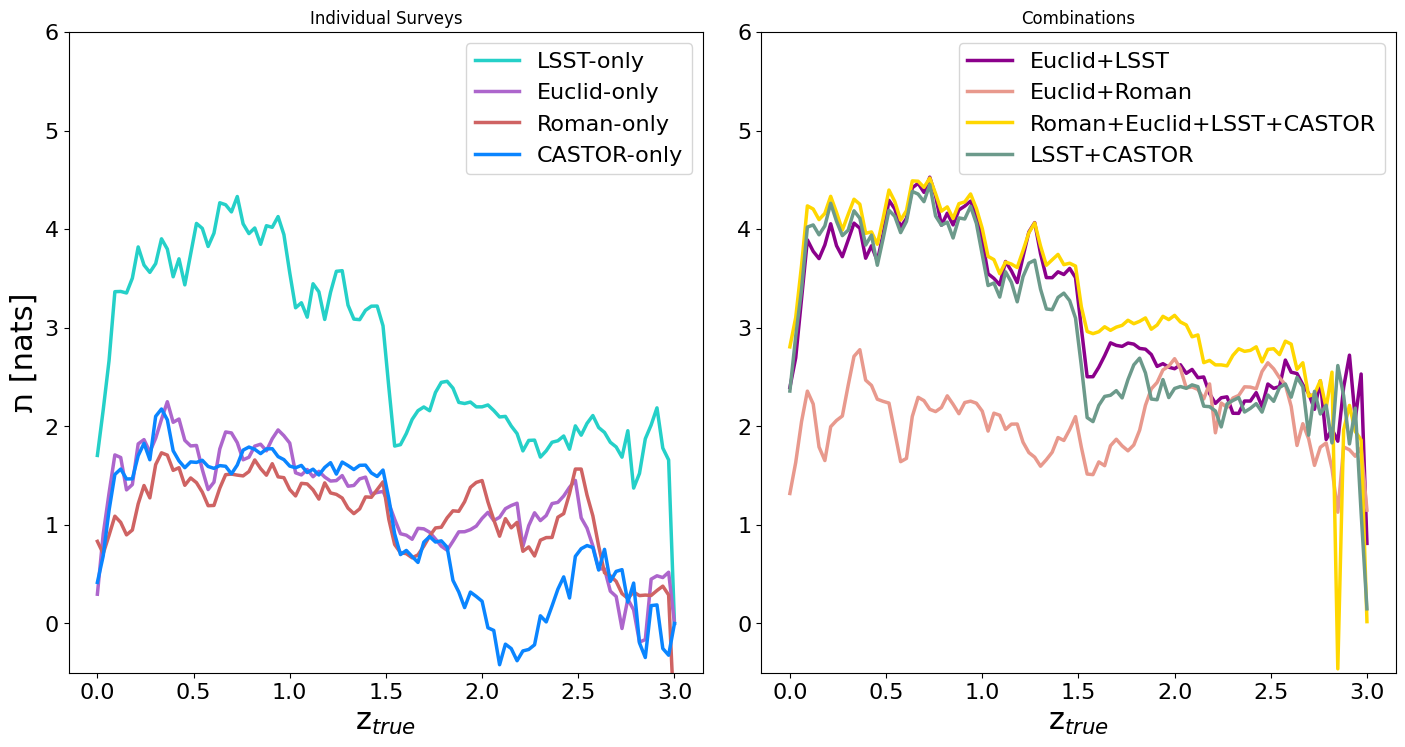

In [33]:
fig, ax = plt.subplots(1, 2, figsize = (14, 7))
fig.tight_layout()

zbins = np.linspace(0, 3, 100)

plt_os_left = ['LSST-only',
               'Euclid-only',
               'Roman-only',
               'CASTOR-only']

plt_os_right = ['Euclid+LSST',
          'Euclid+Roman',
          'Roman+Euclid+LSST+CASTOR',
          'LSST+CASTOR']

col_dict = {}

col_dict['LSST-only'] = '#25D0C8'
col_dict['Euclid-only'] = '#AD66CC'
col_dict['Roman-only'] = '#CF6363'
col_dict['CASTOR-only'] = '#0A85FF'
col_dict['LSST+CASTOR'] = '#6C9A8B'
col_dict['Euclid+Roman'] = '#E8998D'
col_dict['Euclid+LSST'] = '#8B008B'
col_dict['Roman+Euclid+LSST+CASTOR'] = '#FFD700'

# ax[0].plot([], [], ' ', label="Individual Surveys")
# ax[1].plot([], [], ' ', label="Combinations")

for os in plt_os_left:
  print(os)
  print(np.sum(np.isinf(avgtav[os])))
  print(np.min(avgtav[os]))
  ax[0].plot(zbins, avgtav[os], label=os, lw=2.5, color = col_dict[os])
  # ax[0].plot(zbins, errtav[os], label=os, alpha = 0.7
  # ax[1].plot(zbins, errtav[os], label=os, alpha = 0.7)
  # ax[2].plot(zbins, binned_variance[os], label =os, alpha = 0.7)

for os in plt_os_right:
  print(os)
  print(np.sum(np.isinf(avgtav[os])))
  print(np.min(avgtav[os]))
  ax[1].plot(zbins, avgtav[os], label=os, lw=2.5, color = col_dict[os])
  # ax[1].plot(zbins, errtav[os], label=os, alpha=0.7

# ax[0].set_ylim(-10, 5)
# ax[0].legend(fontsize = 8)
ax[0].set_xlabel('z$_{true}$', fontsize=22)
ax[0].set_ylabel(chr(0x05ea)+' [nats]', fontsize=22)
ax[0].set_ylim(-0.5, 6)
ax[0].legend(fontsize=16)
ax[0].tick_params(axis='both', which='major', labelsize=16)
ax[0].tick_params(axis='both', which='minor', labelsize=16)

# ax[0].legend(fontsize = 8)
ax[1].set_xlabel('z$_{true}$', fontsize=22)
ax[1].legend(fontsize=16, loc='upper right')
ax[1].tick_params(axis='both', which='major', labelsize=16)
ax[1].tick_params(axis='both', which='minor', labelsize=16)
# ax[1].set_ylabel('$\sigma$ (' + chr(0x05ea) +')$_s$')
ax[1].set_ylim(-0.5, 6)


# ax[2].set_ylabel('$\sigma$ (' + chr(0x05ea) +')$_E$')
# ax[2].set_xlabel('z$_{true}$')
# ax[2].set_ylim(-0.5, 2)

# plt.savefig('redshift_binned_with_uncertainty_same_scales.png')

ax[0].set_title('Individual Surveys')
ax[1].set_title('Combinations')

plt.show()

i) add individual vs combinations text
ii) maybe a ratio panel - or ratio lines
iii) add units to tav
iv)

**This part makes the uncertainty figure**

In [34]:
def compute_milb_ensemble(just_tav, available_os):

  all_tlm = {}
  all_milb = {}
  all_ent = {}
  is_inf_mask = {}

  print(available_os)

  for os in available_os:
      # print(os_names[os])
      # load the photometric catalog for this os
    cat = catalogs[os]
    # print(cat.shape)

    # Computing the entropy H(z)
    b = sps.mstats.mquantiles(z_true, np.linspace(0,1,101, endpoint=True))

    pz = sps.rv_histogram(np.histogram(z_true, bins=b))
    entropy = pz.entropy()
    # just checking that this isn't discrete entropy and that binning doesn't need to match anything else
    # testent = sum(-1 * pz.logpdf(b_centers) * pz.pdf(b_centers) * db)
    # print(entropy - testent)
    all_ent[os] = entropy


    # Computing lower bound
    # all_milb = []
    # print(len(flows[os]))
    # for i in range(10):
    milb = just_tav[os]
    # print(np.sum(np.isinf(milb)))
    # print(np.sum(np.isnan(milb)))
    # print(np.shape(milb[0,:]))
      # print(milb)
    all_milb[os] = np.array(milb)
      # print(np.shape(all_milb[os]))
    all_tlm[os] = all_milb[os] + entropy
    is_inf_mask[os] = np.isinf(all_tlm[os])
    # all_tlm[os] = all_tlm[os][~np.isinf(all_tlm[os])]
    # print(np.sum(np.isinf(all_tlm[os])))

    # print('shape is: ')
    # print(np.shape(all_tlm[os]))
  return all_tlm, is_inf_mask

In [35]:
all_tlm, is_inf_mask = compute_milb_ensemble(just_tav, available_os)

epistemic_variance = {}
redshifts = {}

for os in available_os:
  epistemic_variance[os] = all_tlm[os].std(axis=1)
  redshifts[os] = catalogs[os]['z_true']

binned_variance = {}

for os in available_os:
  print(epistemic_variance[os].shape)
  print(redshifts[os].shape)

  ploterr = np.empty_like(zbins)
  for i, zmin in enumerate(zbins[:-1]):
      zmax = zbins[i+1]
      ploterr[i] = np.mean(epistemic_variance[os][(redshifts[os] >=zmin) & (redshifts[os] < zmax)])

      binned_variance[os] = ploterr

['LSST-only', 'Roman-only', 'CASTOR-only', 'Euclid-only', 'Euclid+Roman', 'Roman+Euclid+LSST+CASTOR', 'LSST+CASTOR', 'Euclid+LSST', 'Euclid-only', 'Euclid+CASTOR']


<ipython-input-34-2c69b1faeef8>:19: RuntimeWarning: Bin widths are not constant. Assuming `density=True`.Specify `density` explicitly to silence this warning.
  pz = sps.rv_histogram(np.histogram(z_true, bins=b))


(116127,)
(116127,)
(360862,)
(360862,)
(225481,)
(225481,)
(152739,)
(152739,)
(152240,)
(152240,)
(96430,)
(96430,)
(103343,)
(103343,)
(108057,)
(108057,)
(152739,)
(152739,)
(121238,)
(121238,)


LSST-only
0
2.042e-320
Euclid-only
0
-0.18921197950839996
Roman-only
0
-1.0256441732872812
CASTOR-only
0
-0.4188786447048187
LSST+CASTOR
0
0.14834104478359222
Euclid+Roman
0
1.1282364130020142
Euclid+LSST
0
0.8118856197547899
Roman+Euclid+LSST+CASTOR
0
-0.4604508876800537


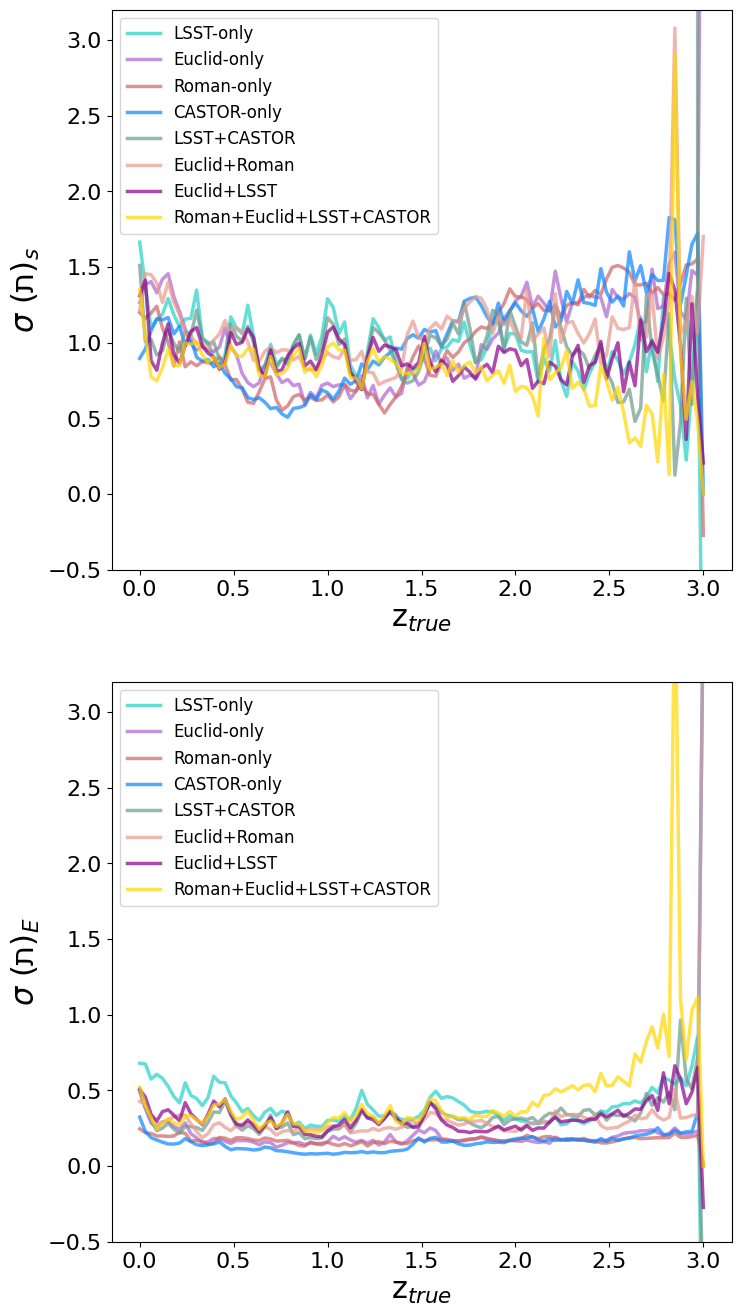

In [36]:
fig, ax = plt.subplots(2,1, figsize = (8, 16))

zbins = np.linspace(0, 3, 100)

plt_os = ['LSST-only',
               'Euclid-only',
               'Roman-only',
               'CASTOR-only',
               'LSST+CASTOR',
              'Euclid+Roman',
              'Euclid+LSST',
              'Roman+Euclid+LSST+CASTOR']



for os in plt_os:
  print(os)
  print(np.sum(np.isinf(avgtav[os])))
  print(np.min(avgtav[os]))
  # ax[0].plot(zbins, avgtav[os], label=os, alpha=0.7)
  ax[0].plot(zbins, errtav[os], label=os, lw=2.5, alpha = 0.7, color = col_dict[os])
  ax[1].plot(zbins, binned_variance[os], lw=2.5, label =os, alpha = 0.7, color = col_dict[os])

# for os in plt_os_right:
#   print(os)
#   print(np.sum(np.isinf(avgtav[os])))
#   print(np.min(avgtav[os]))
#   ax[1].plot(zbins, avgtav[os], label=os, alpha=0.7)

# ax[0].set_ylim(-10, 5)
# ax[0].legend(fontsize = 8)
ax[0].set_xlabel('z$_{true}$', fontsize = 22)
ax[0].set_ylim(-0.5, 3.2)
ax[0].legend(fontsize=12)

# ax[0].legend(fontsize = 8)
ax[1].set_xlabel('z$_{true}$', fontsize=22)
ax[1].legend(fontsize=12)
ax[1].set_ylim(-0.5, 3.2)
ax[0].set_ylabel('$\sigma$ (' + chr(0x05ea) +')$_s$', fontsize=22)
ax[1].set_ylabel('$\sigma$ (' + chr(0x05ea) +')$_E$', fontsize=22)
# ax[1].set_ylim(-0.5, 2)

ax[1].tick_params(axis='both', which='major', labelsize=16)
ax[1].tick_params(axis='both', which='minor', labelsize=16)

ax[0].tick_params(axis='both', which='major', labelsize=16)
ax[0].tick_params(axis='both', which='minor', labelsize=16)

the peaks here probably correspond to the LSST filters - refer to Melissa graham's papers -> z_spec, z_phot paper

these are busy - can we make this more readable
emphasize that the model uncertainty in CASTOR-only does not peak at 1.6
highlight the degeneracy redshift
rework the colors

**This makes the new version of Figure 2 - the CDF plots and point-wise information gain figure**

I need to train one more Euclid+CASTOR model which is not saved and read back in properly above. I would just ignore parts that make reference to it if you're focused on polishing the figures - I'll get those last ensembles trained and added in as soon as I'm back to the US.

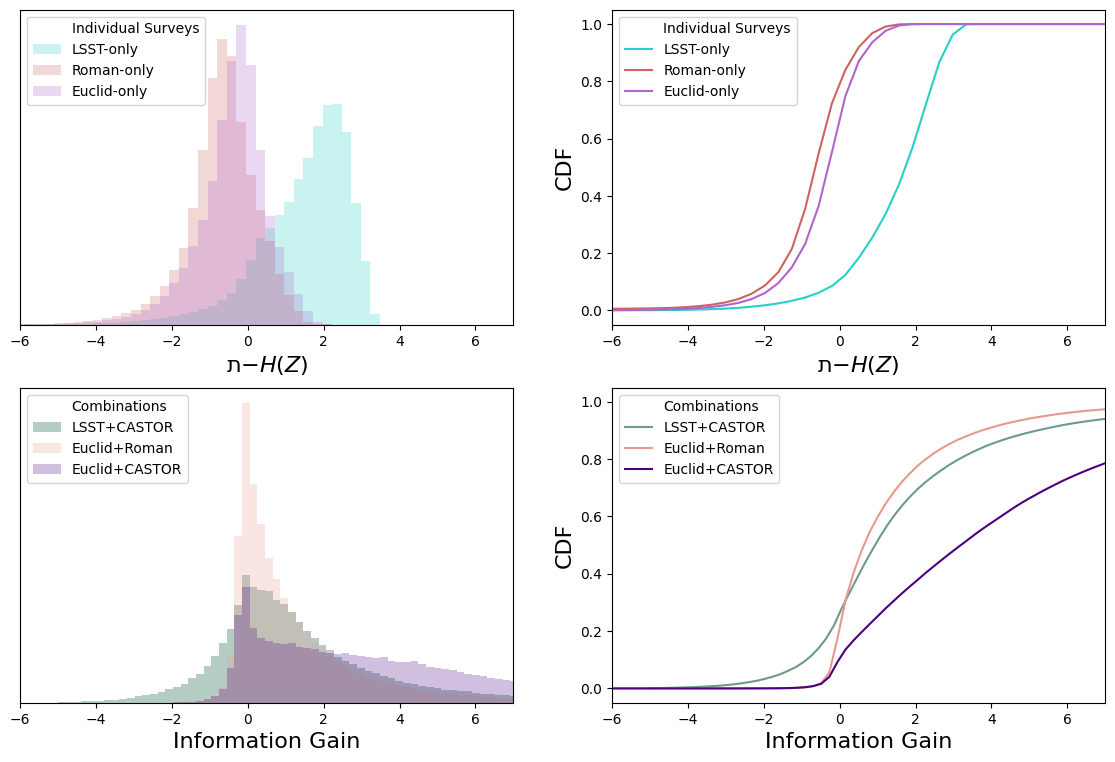

In [37]:
# col_dict['Euclid+CASTOR'] = 'indigo'

tav = just_tav

fig, ax = plt.subplots(2, 2, figsize=(14, 9))#, sharex=True)
delta_tav_agg = []
# which_plt = 0
# for os in ['LSST-only', 'Roman-only', 'Euclid-only']:
#   ax[which_plt].hist(tav_cats[os]['z_true'], alpha=0.25, label=os[:-5], density=True, bins=100)
#   ax[which_plt].legend()
#   ax[which_plt].set_xlim(0, 5)
#   ax[which_plt].set_xlabel(r'$z$') #r'$\mathbb{E}_{z, x_{phot}} \left[ q_\theta(z | x_{phot}) \right]$')
#   ax[which_plt].set_yticks([])

ax[0, 0].plot([], [], ' ', label="Individual Surveys")
ax[0, 1].plot([], [], ' ', label="Individual Surveys")

ax[1,0].plot([], [], ' ', label="Combinations")
ax[1,1].plot([], [], ' ', label="Combinations")

for os in ['LSST-only', 'Roman-only', 'Euclid-only']:
  delta_tav_agg.append(tav[os].mean(axis=1))
  ax[0,0].hist(tav[os].mean(axis=1), alpha=0.25, label=os, density=True, bins=np.linspace(-20, 5, 100), color = col_dict[os])
  ax[0,0].legend()
  ax[0,0].set_xlim(-6, 7)
  ax[0,0].set_xlabel(chr(0x05ea)+r'$-H(Z)$', fontsize=16) #r'$\mathbb{E}_{z, x_{phot}} \left[ q_\theta(z | x_{phot}) \right]$')
  ax[0,0].set_yticks([])
which_plt = 1

for os in ['LSST-only', 'Roman-only', 'Euclid-only']:
  delta_tav_agg.append(tav[os].mean(axis=1))
  xran = np.linspace(-20, 15, 100)
  to_plot = sps.ecdf(tav[os].mean(axis=1)).cdf.evaluate(xran)
  ax[0,1].plot(xran, to_plot, label=os, color = col_dict[os])
  ax[0,1].legend()
  ax[0,1].set_xlim(-6, 7)
  ax[0,1].set_xlabel(chr(0x05ea)+r'$-H(Z)$', fontsize=16) #r'$\mathbb{E}_{z, x_{phot}} \left[ q_\theta(z | x_{phot}) \right]$')
  # ax[which_plt].set_yticks([])
  ax[0,1].set_ylabel('CDF', fontsize=16)

common_indices = catalogs['LSST+CASTOR'].index.intersection(catalogs['LSST-only'].index)

tav['LSST-only'] = flows['LSST-only'].log_prob(catalogs['LSST-only'].loc[common_indices], returnEnsemble = True)
tav['LSST+CASTOR'] = flows['LSST+CASTOR'].log_prob(catalogs['LSST+CASTOR'].loc[common_indices], returnEnsemble = True)

common_indices = catalogs['Euclid+Roman'].index.intersection(catalogs['Euclid-only'].index)

tav['Euclid-only'] = flows['Euclid-only'].log_prob(catalogs['Euclid-only'].loc[common_indices], returnEnsemble = True)
tav['Euclid+Roman'] = flows['Euclid+Roman'].log_prob(catalogs['Euclid+Roman'].loc[common_indices], returnEnsemble = True)

common_indices = catalogs['Euclid+CASTOR'].index.intersection(catalogs['Euclid-only'].index)

tav['Euclid-only2'] = flows['Euclid-only'].log_prob(catalogs['Euclid-only'].loc[common_indices], returnEnsemble = True) # this is where the bug is here, common_indices changes but tav['Euclid-only'] shouldn't for the next cell to work properly
tav['Euclid+CASTOR'] = flows['Euclid+CASTOR'].log_prob(catalogs['Euclid+CASTOR'].loc[common_indices], returnEnsemble = True)

delta_tav_agg = []

delta_tav_agg = tav['LSST-only'].mean(axis=1)
delta_tav_agg = np.exp(tav['LSST+CASTOR'].mean(axis=1)) * (tav['LSST+CASTOR'].mean(axis=1) - delta_tav_agg)

ax[1,0].hist(delta_tav_agg, alpha=0.5, density=True, bins=np.linspace(-5, 15, 100), label = 'LSST+CASTOR', color = col_dict['LSST+CASTOR'])

delta_tav_agg = tav['Euclid-only'].mean(axis=1)
delta_tav_agg = np.exp(tav['Euclid+Roman'].mean(axis=1)) * (tav['Euclid+Roman'].mean(axis=1) - delta_tav_agg)

ax[1,0].hist(delta_tav_agg, alpha=0.25, density=True, bins=np.linspace(-5, 15, 100), label = 'Euclid+Roman', color = col_dict['Euclid+Roman'])

delta_tav_agg = tav['Euclid-only2'].mean(axis=1)
delta_tav_agg = np.exp(tav['Euclid+CASTOR'].mean(axis=1)) * (tav['Euclid+CASTOR'].mean(axis=1) - delta_tav_agg)

ax[1,0].hist(delta_tav_agg, alpha=0.25, density=True, bins=np.linspace(-5, 15, 100), label = 'Euclid+CASTOR', color = col_dict['Euclid+CASTOR'])

ax[1,0].legend(loc='upper left')
ax[1,0].set_xlim(-6, 7)
ax[1,0].set_xlabel('Information Gain', fontsize=16)
# ax[1,0].set_xlabel(chr(0x05ea)+r'$-H(Z)$', fontsize=16) #r'$\mathbb{E}_{z, x_{phot}} \left[ q_\theta(z | x_{phot}) \right]$')
ax[1,0].set_yticks([])

delta_tav_agg = tav['LSST-only'].mean(axis=1)
delta_tav_agg = np.exp(tav['LSST+CASTOR'].mean(axis=1)) * (tav['LSST+CASTOR'].mean(axis=1) - delta_tav_agg)

xran = np.linspace(-5, 15, 100)
to_plot = sps.ecdf(delta_tav_agg).cdf.evaluate(xran)
ax[1,1].plot(xran, to_plot, label='LSST+CASTOR', color = col_dict['LSST+CASTOR'])

delta_tav_agg = tav['Euclid-only'].mean(axis=1)
delta_tav_agg = np.exp(tav['Euclid+Roman'].mean(axis=1)) * (tav['Euclid+Roman'].mean(axis=1) - delta_tav_agg)

xran = np.linspace(-6, 15, 100)
to_plot = sps.ecdf(delta_tav_agg).cdf.evaluate(xran)
ax[1,1].plot(xran, to_plot, label='Euclid+Roman', color = col_dict['Euclid+Roman'])

delta_tav_agg = tav['Euclid-only2'].mean(axis=1)
delta_tav_agg = np.exp(tav['Euclid+CASTOR'].mean(axis=1)) * (tav['Euclid+CASTOR'].mean(axis=1) - delta_tav_agg)

xran = np.linspace(-6, 15, 100)
to_plot = sps.ecdf(delta_tav_agg).cdf.evaluate(xran)
ax[1,1].plot(xran, to_plot, label='Euclid+CASTOR', color = col_dict['Euclid+CASTOR'])

ax[1,1].set_xlim(-6, 7)
ax[1,1].set_xlabel('Information Gain', fontsize=16)
# ax[1,1].set_xlabel(chr(0x05ea)+r'$-H(Z)$', fontsize=16) #r'$\mathbb{E}_{z, x_{phot}} \left[ q_\theta(z | x_{phot}) \right]$')
# ax[which_plt].set_yticks([])
ax[1,1].set_ylabel('CDF', fontsize=16)

ax[1,1].legend()

updated colors, increase font sizes
highlight in legend which is single and which is combinations
play with spacing on axes labels that can look like headings

In [ ]:
delta_tav_agg

Array([10.028802  ,  6.383808  ,  4.2241845 , ..., -0.01888924,
        3.507806  , -0.5121518 ], dtype=float32)

In [ ]:
# now want to look at the top 0.1% of the improvement in the KLD for each survey combination
tav = just_tav

delta_tav_agg = {}
common_index_dict = {}

delta_tav_os = ['LSST+CASTOR',
                'Roman+Euclid',
                'Euclid+CASTOR']

common_indices = catalogs['LSST+CASTOR'].index.intersection(catalogs['LSST-only'].index)
common_index_dict['LSST+CASTOR'] = common_indices

tav['LSST-only'] = flows['LSST-only'].log_prob(catalogs['LSST-only'].loc[common_indices], returnEnsemble = True)
tav['LSST+CASTOR'] = flows['LSST+CASTOR'].log_prob(catalogs['LSST+CASTOR'].loc[common_indices], returnEnsemble = True)

delta_tav_agg['LSST+CASTOR'] = tav['LSST-only'].mean(axis=1)
delta_tav_agg['LSST+CASTOR'] = np.exp(tav['LSST+CASTOR'].mean(axis=1)) * (tav['LSST+CASTOR'].mean(axis=1) - delta_tav_agg['LSST+CASTOR'])

common_indices = catalogs['Euclid+Roman'].index.intersection(catalogs['Euclid-only'].index)
common_index_dict['Euclid+Roman'] = common_indices

tav['Euclid-only'] = flows['Euclid-only'].log_prob(catalogs['Euclid-only'].loc[common_indices], returnEnsemble = True)
tav['Euclid+Roman'] = flows['Euclid+Roman'].log_prob(catalogs['Euclid+Roman'].loc[common_indices], returnEnsemble = True)

delta_tav_agg['Euclid+Roman'] = tav['Euclid-only'].mean(axis=1)
delta_tav_agg['Euclid+Roman'] = np.exp(tav['Euclid+Roman'].mean(axis=1)) * (tav['Euclid+Roman'].mean(axis=1) - delta_tav_agg['Euclid+Roman'])

common_indices = catalogs['Euclid+CASTOR'].index.intersection(catalogs['Euclid-only'].index)
common_index_dict['Euclid+CASTOR'] = common_indices


tav['Euclid-only2'] = flows['Euclid-only'].log_prob(catalogs['Euclid-only'].loc[common_indices], returnEnsemble = True) # this is where the bug is here, common_indices changes but tav['Euclid-only'] shouldn't for the next cell to work properly
tav['Euclid+CASTOR'] = flows['Euclid+CASTOR'].log_prob(catalogs['Euclid+CASTOR'].loc[common_indices], returnEnsemble = True)

delta_tav_agg['Euclid+CASTOR'] = tav['Euclid-only2'].mean(axis=1)
delta_tav_agg['Euclid+CASTOR'] = np.exp(tav['Euclid+CASTOR'].mean(axis=1)) * (tav['Euclid+CASTOR'].mean(axis=1) - delta_tav_agg['Euclid+CASTOR'])

In [ ]:
delta_tav_dict, kld_lo, kld_hi = {}, {}, {}

for i, os in enumerate(['LSST+CASTOR', 'Euclid+Roman', 'Euclid+CASTOR']):
  kld_lo[os] = np.percentile(delta_tav_agg[os], 0.1)
  kld_hi[os] = np.percentile(delta_tav_agg[os], 99.9)
  print(os, kld_lo[os], kld_hi[os])

LSST+CASTOR -4.943881067276001 26.723331951141983
Euclid+Roman -1.2900155398845672 15.686656657220338
Euclid+CASTOR -1.4289024938344956 39.84955825805679


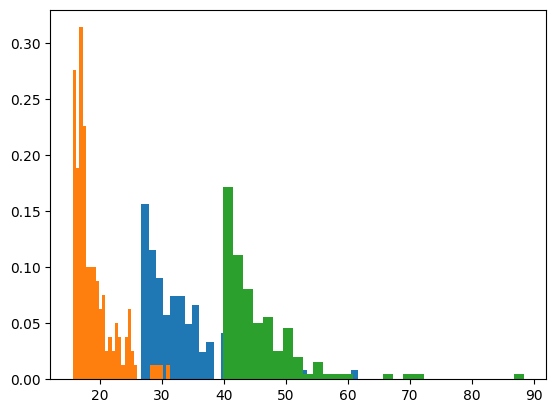

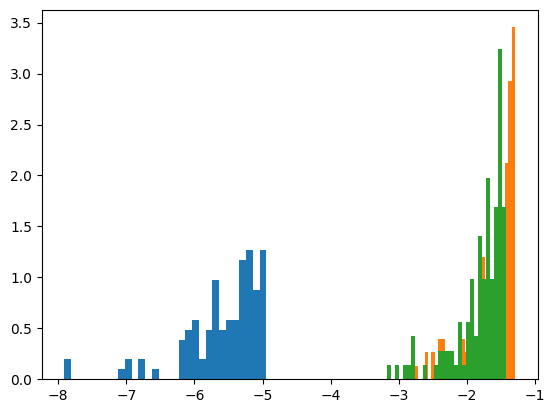

In [ ]:
for os in ['LSST+CASTOR', 'Euclid+Roman', 'Euclid+CASTOR']:
  plt.hist(delta_tav_agg[os][delta_tav_agg[os] >= kld_hi[os]], bins = 30, density=True)

plt.show()

for os in ['LSST+CASTOR', 'Euclid+Roman', 'Euclid+CASTOR']:
  plt.hist(delta_tav_agg[os][delta_tav_agg[os] <= kld_lo[os]], bins = 30, density=True)

In [ ]:
improved = {}
worsened = {}
improved_indexes = {}
worsened_indexes = {}

for i, os in enumerate(['LSST+CASTOR', 'Euclid+Roman', 'Euclid+CASTOR']):
  improved[os] = delta_tav_agg[os][delta_tav_agg[os] >= kld_hi[os]]
  # print('improved for {}'.format(os))
  improved_indexes[os] = np.where(delta_tav_agg[os] >= kld_hi[os])
  # improved[os] = delta_tav_dict[os][delta_tav_dict[os] >= 10.]
  # print('least improved for {}'.format(os))
  worsened[os] = delta_tav_agg[os][delta_tav_agg[os] <= kld_lo[os]]
  worsened_indexes[os] = np.where(delta_tav_agg[os] >= kld_lo[os])

need to figure out how to highlight the 10 most and least improved

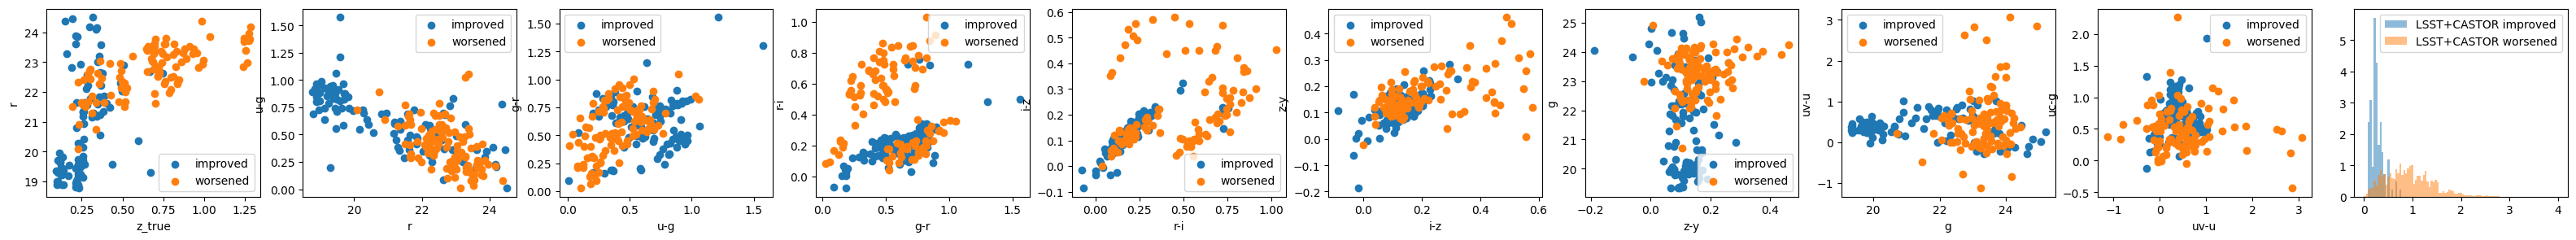

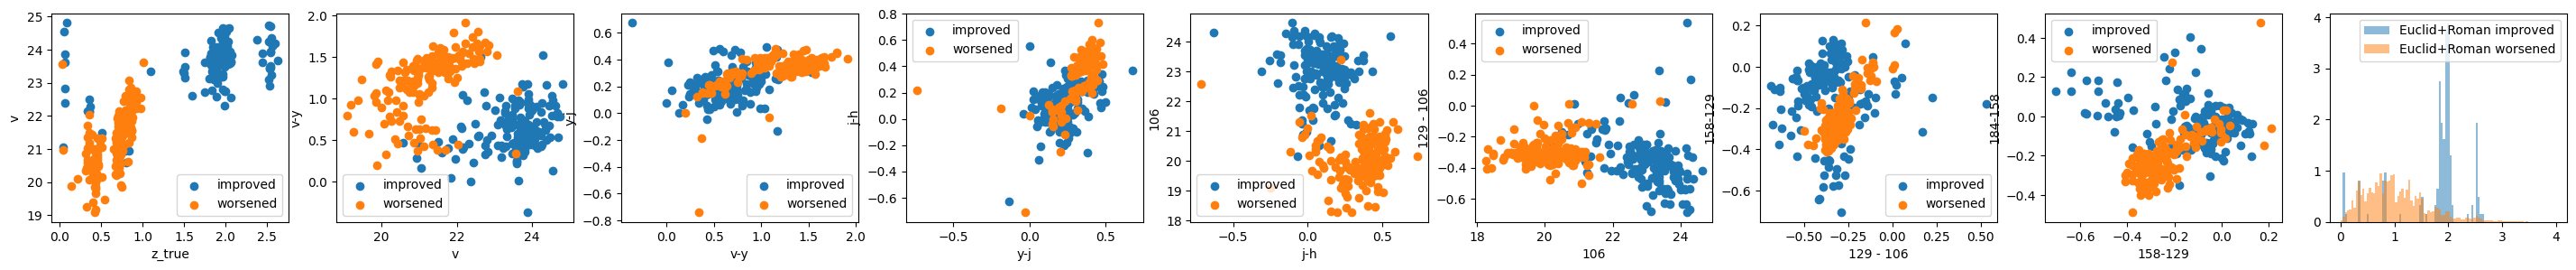

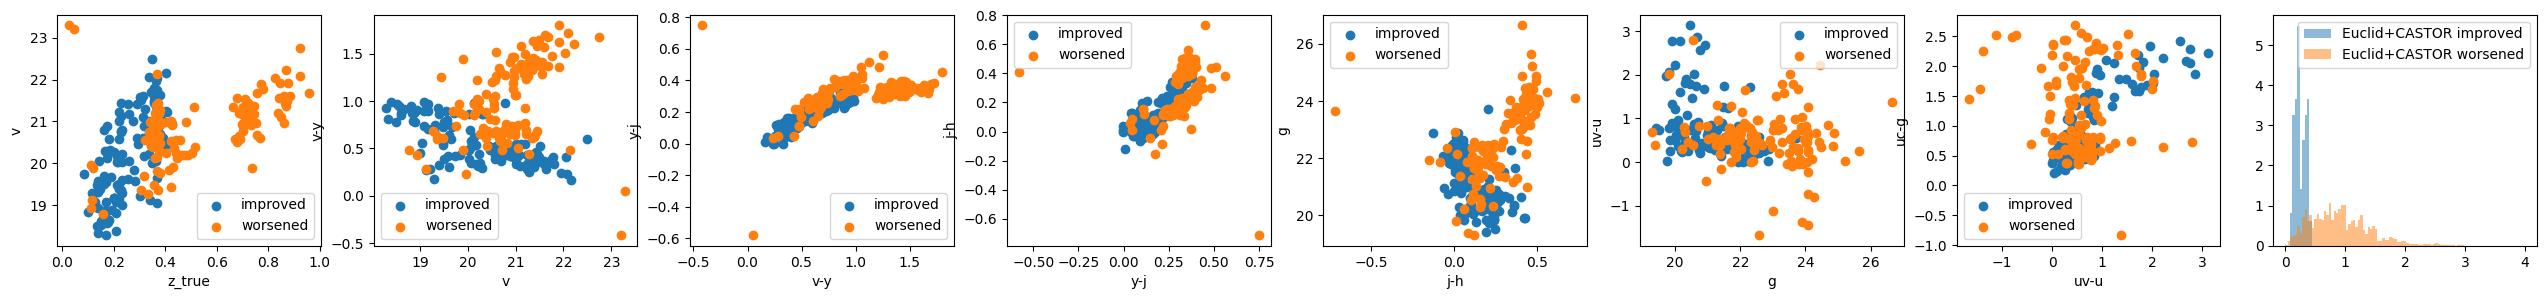

In [ ]:
for j, os in enumerate(['LSST+CASTOR', 'Euclid+Roman', 'Euclid+CASTOR']):
    tot_plots = len(catalogs[os].columns)
    fig, ax = plt.subplots(1, tot_plots, figsize = (tot_plots * 4, 3))

    subset = catalogs[os].loc[common_index_dict[os]][np.array(delta_tav_agg[os]) >= kld_hi[os]]


    for i, color_col in enumerate(catalogs[os].columns[:-1]):
      ax[i].scatter(subset[color_col], subset[subset.columns[i+1]], label = 'improved')
      ax[i].set_xlabel(color_col)
      ax[i].set_ylabel(subset.columns[i+1])
      # ax[i].scatter(best_subset[color_col], best_subset[best_subset.columns[i+1]], marker = '+', label = '10 best')

    subset = catalogs[os][np.array(delta_tav_agg[os]) <= kld_lo[os]]

    for i, color_col in enumerate(catalogs[os].columns.values[:-1]):
      ax[i].scatter(subset[color_col], subset[subset.columns[i+1]], label = 'worsened')
      # ax[i].scatter(worst_subset[color_col], worst_subset[worst_subset.columns[i+1]], marker = 'x', label = '10 worst')

      ax[i].legend()

    ax[i+1].hist(np.array(catalogs[os]['z_true'])[improved_indexes[os]], bins=np.linspace(0, 4, 100), label = os+' improved', alpha=0.5, density=True)
    ax[i+1].hist(np.array(catalogs[os]['z_true'])[worsened_indexes[os]], bins=np.linspace(0, 4, 100), label = os+' worsened', alpha=0.5, density=True)

    ax[i+1].legend()

In [ ]:
delta_tav_agg

{'LSST+CASTOR': Array([ 1.1121158e+01, -1.0194316e-01,  1.8806261e+00, ...,
         4.0102286e+00,  7.0031215e-03,  4.7065663e-01], dtype=float32),
 'Euclid+Roman': Array([ 0.83356994,  3.0514789 ,  3.882718  , ..., -0.02201208,
         1.2340132 , -0.44415486], dtype=float32),
 'Euclid+CASTOR': Array([10.028802  ,  6.383808  ,  4.2241845 , ..., -0.01888924,
         3.507806  , -0.5121518 ], dtype=float32)}

In [ ]:
np.argsort(delta_tav_agg['LSST+CASTOR'])

Array([75095, 85945, 95142, ..., 83356, 69815, 16745], dtype=int32)

In [ ]:
(np.array(delta_tav_agg[os]) >= kld_hi[os])[np.argsort(delta_tav_agg[os])]

array([False, False, False, ...,  True,  True,  True])

In [ ]:
subset = catalogs[os].loc[common_index_dict[os]][np.array(delta_tav_agg[os]) >= kld_hi[os]]



           z_true          v       v-y       y-j       j-h          g  \
CASTOR_ID                                                               
13402      0.1907  18.888979  0.777647  0.267996  0.234165  20.008321   
26018      0.4063  21.231335  0.278480  0.089107 -0.067208  22.069216   
32574      0.2897  20.598862  0.451568  0.148575  0.009784  21.493994   
41799      0.1739  20.125612  0.615837  0.162463  0.044257  21.018459   
46422      0.3793  21.634681  0.283493  0.098721 -0.000943  22.442245   
...           ...        ...       ...       ...       ...        ...   
943942     0.1600  18.846312  0.873078  0.283985  0.237927  20.030903   
951071     0.4088  20.450474  0.525247  0.193529  0.094908  21.460471   
958902     0.1599  19.706070  0.874487  0.305027  0.256306  20.873565   
959920     0.2293  19.371096  0.926451  0.295457  0.227446  20.714667   
962226     0.2802  19.578840  0.417523  0.129912  0.102343  20.408778   

               uv-u      uc-g  
CASTOR_ID         

In [ ]:
catalogs[os].loc[common_index_dict[os]] #.iloc[improved_indexes[os]]

,z_true,v,v-y,y-j,j-h,g,uv-u,uc-g
CASTOR_ID,,,,,,,,
13402,0.1907,18.888979,0.777647,0.267996,0.234165,20.008321,1.205394,1.328685
26018,0.4063,21.231335,0.278480,0.089107,-0.067208,22.069216,0.087297,0.235348
32574,0.2897,20.598862,0.451568,0.148575,0.009784,21.493994,0.324617,0.706065
41799,0.1739,20.125612,0.615837,0.162463,0.044257,21.018459,0.352627,1.164937
46422,0.3793,21.634681,0.283493,0.098721,-0.000943,22.442245,0.180644,0.322894
...,...,...,...,...,...,...,...,...
943942,0.1600,18.846312,0.873078,0.283985,0.237927,20.030903,0.791773,1.566394
951071,0.4088,20.450474,0.525247,0.193529,0.094908,21.460471,0.832596,0.498274
958902,0.1599,19.706070,0.874487,0.305027,0.256306,20.873565,1.660322,1.585236


In [ ]:
for os in ['LSST+CASTOR', 'Euclid+Roman', 'Euclid+CASTOR']:
  print('improved for {}'.format(os))
  print(catalogs[os].iloc[np.array(improved_indexes[os]).flatten()[np.argsort(improved[os])]].index)


  print('worsened for {}'.format(os))
  print(catalogs[os].iloc[np.array(worsened_indexes[os]).flatten()[np.argsort(worsened[os])]].index)

improved for LSST+CASTOR
Index([752211,  72693, 714543, 544307, 479141, 672915, 920324, 562343,  49319,
       278223,
       ...
       558758, 321496, 303687, 924675, 938539, 592223, 582878, 797075, 673422,
       163785],
      dtype='int64', name='CASTOR_ID', length=104)
worsened for LSST+CASTOR
Index([1038, 1204, 1388,  261,  692,  265,  332,  740,  982,  238,
       ...
        462,  371, 1447,  681,  711,  187,  529, 1122, 1262, 1021],
      dtype='int64', name='CASTOR_ID', length=104)
improved for Euclid+Roman
Index([616787,  42639, 923841, 326165, 763378, 809329, 963440, 791495, 419944,
       175134,
       ...
       573336, 242436, 492642, 252173, 672939, 203147, 233784, 699544, 512042,
        36158],
      dtype='int64', name='CASTOR_ID', length=153)
worsened for Euclid+Roman
Index([ 181, 1245,  773,  118,  744,  529,  701, 1218,  307, 1213,
       ...
       1552,   57,  942,    3, 1001, 1152,  140,  666,  452,  337],
      dtype='int64', name='CASTOR_ID', length=153)
im

In [ ]:
catalogs[os].keys()

Index(['z_true', 'r', 'u-g', 'g-r', 'r-i', 'i-z', 'z-y', 'g', 'uv-u', 'uc-g'], dtype='object')

In [ ]:
import matplotlib.colors as colors

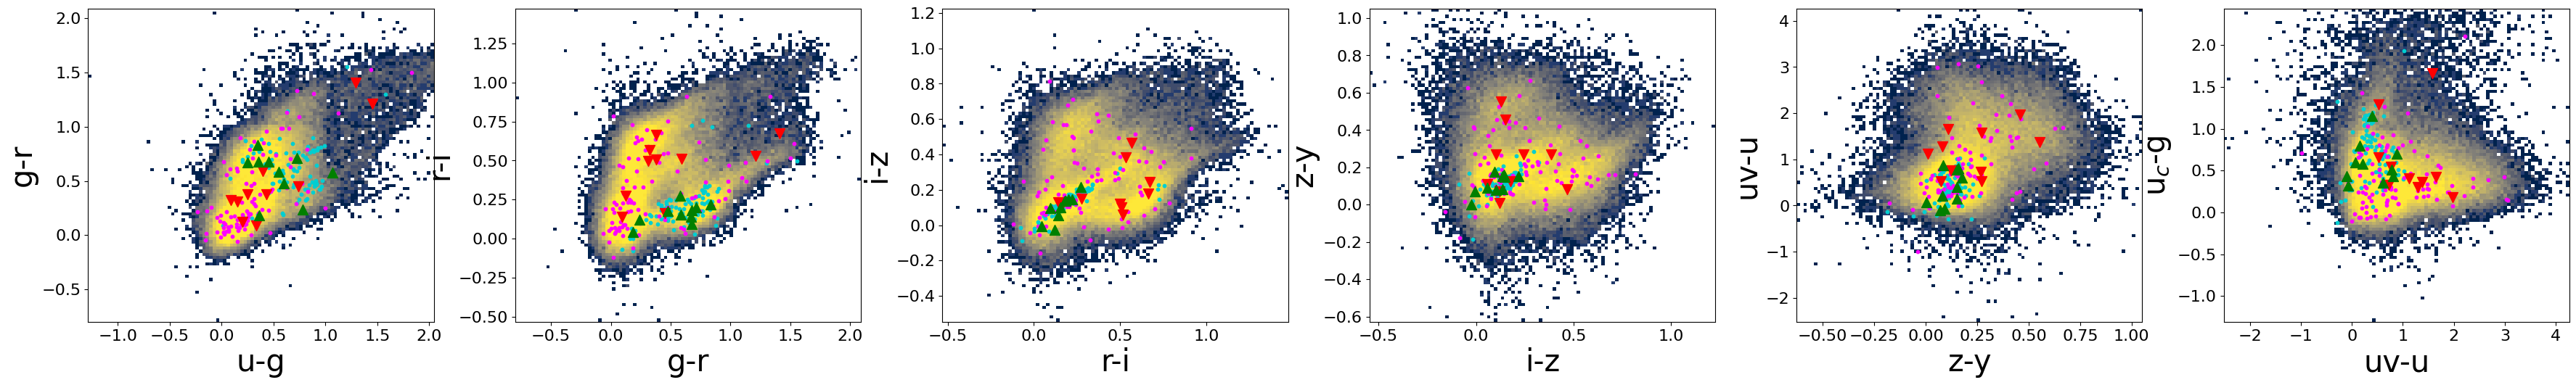

In [ ]:
os = 'LSST+CASTOR'

test_best = catalogs[os].iloc[np.array(improved_indexes[os]).flatten()[np.argsort(improved[os])]]
best_subset = catalogs[os].iloc[np.array(improved_indexes[os]).flatten()[np.argsort(improved[os])]][0:10]

test_worst = catalogs[os].iloc[np.array(worsened_indexes[os]).flatten()[np.argsort(worsened[os])]]
worst_subset = catalogs[os].iloc[np.array(worsened_indexes[os]).flatten()[np.argsort(worsened[os])]][0:10]
# print(worsened[os][np.argsort(worsened[os])])

fig,ax = plt.subplots(1,6, figsize = (36, 6))
fig.tight_layout(pad = 5)

band1 = 'u-g'
band2 = 'g-r'

size = 100
fsize = 30

dotsize = 10
bestcolor = 'darkturquoise'
worstcolor = 'magenta'
verybestcolor = 'green'
veryworstcolor = 'red'
verybestmarker = '^'
veryworstmarker = 'v'

cmap_choice = 'cividis'

ax[0].hist2d(catalogs[os][band1], catalogs[os][band2], bins = (100,100), cmap=cmap_choice, norm = colors.LogNorm(vmin=1, vmax=100))
ax[0].scatter(test_best[band1], test_best[band2], s = 10, color = bestcolor)
ax[0].scatter(test_worst[band1], test_worst[band2], s=10, color = worstcolor)
ax[0].scatter(worst_subset[band1],  worst_subset[band2], marker = veryworstmarker, color = 'red', s=size)
ax[0].scatter(best_subset[band1], best_subset[band2], marker = verybestmarker, color = 'green', s=size)
ax[0].set_xlabel(band1, fontsize=fsize)
ax[0].set_ylabel(band2, fontsize=fsize)

band1 = 'g-r'
band2 = 'r-i'

ax[1].hist2d(catalogs[os][band1], catalogs[os][band2], bins = (100,100), cmap=cmap_choice, norm = colors.LogNorm(vmin=1, vmax=100))
ax[1].scatter(test_best[band1], test_best[band2], s=10, color = bestcolor)
ax[1].scatter(test_worst[band1], test_worst[band2], s=10, color = worstcolor)
ax[1].scatter(worst_subset[band1],  worst_subset[band2], marker = veryworstmarker, color = 'red', s=size)
ax[1].scatter(best_subset[band1], best_subset[band2], marker = verybestmarker, color = 'green', s=size)
ax[1].set_xlabel(band1)
ax[1].set_ylabel(band2)
ax[1].set_xlabel(band1, fontsize=fsize)
ax[1].set_ylabel(band2, fontsize=fsize)

band1 = 'r-i'
band2 = 'i-z'

ax[2].hist2d(catalogs[os][band1], catalogs[os][band2], bins = (100,100), cmap=cmap_choice, norm = colors.LogNorm(vmin=1, vmax=100))
ax[2].scatter(test_best[band1], test_best[band2], s=10, color = bestcolor)
ax[2].scatter(test_worst[band1], test_worst[band2], s=10, color = worstcolor)
ax[2].scatter(worst_subset[band1],  worst_subset[band2], marker = veryworstmarker, color = 'red', s=size)
ax[2].scatter(best_subset[band1], best_subset[band2], marker = verybestmarker, color = 'green', s=size)
ax[2].set_xlabel(band1)
ax[2].set_ylabel(band2)
ax[2].set_xlabel(band1, fontsize=fsize)
ax[2].set_ylabel(band2, fontsize=fsize)

band1 = 'i-z'
band2 = 'z-y'

ax[3].hist2d(catalogs[os][band1], catalogs[os][band2], bins = (100,100), cmap=cmap_choice, norm = colors.LogNorm(vmin=1, vmax=100))
ax[3].scatter(test_best[band1], test_best[band2], s=10, color = bestcolor)
ax[3].scatter(test_worst[band1], test_worst[band2], s=10, color = worstcolor)
ax[3].scatter(worst_subset[band1],  worst_subset[band2], marker = veryworstmarker, color = 'red', s=size)
ax[3].scatter(best_subset[band1], best_subset[band2], marker = verybestmarker, color = 'green', s=size)
ax[3].set_xlabel(band1)
ax[3].set_ylabel(band2)
ax[3].set_xlabel(band1, fontsize=fsize)
ax[3].set_ylabel(band2, fontsize=fsize)

band1 = 'z-y'
band2 = 'uv-u'

ax[4].hist2d(catalogs[os][band1], catalogs[os][band2], bins = (100,100), cmap=cmap_choice, norm = colors.LogNorm(vmin=1, vmax=100))
ax[4].scatter(test_best[band1], test_best[band2], s=10, color = bestcolor)
ax[4].scatter(test_worst[band1], test_worst[band2], s=10, color = worstcolor)
ax[4].scatter(worst_subset[band1],  worst_subset[band2], marker = veryworstmarker, color = 'red', s=size)
ax[4].scatter(best_subset[band1], best_subset[band2], marker = verybestmarker, color = 'green', s=size)
ax[4].set_xlabel(band1)
ax[4].set_ylabel(band2)
ax[4].set_xlabel(band1, fontsize=fsize)
ax[4].set_ylabel(band2, fontsize=fsize)

band1 = 'uv-u'
band2 = 'uc-g'

ax[5].hist2d(catalogs[os][band1], catalogs[os][band2], bins = (100,100), cmap=cmap_choice, norm = colors.LogNorm(vmin=1, vmax=100))
ax[5].scatter(test_best[band1], test_best[band2], s = 10, color = bestcolor)
ax[5].scatter(test_worst[band1], test_worst[band2], s = 10, color = worstcolor)
ax[5].scatter(worst_subset[band1],  worst_subset[band2], marker = veryworstmarker, color = 'red', s=size)
ax[5].scatter(best_subset[band1], best_subset[band2], marker = verybestmarker, color = 'green', s=size)
ax[5].set_xlabel(band1)
ax[5].set_ylabel(band2)
ax[5].set_xlabel(band1, fontsize=fsize)
ax[5].set_ylabel('u$_c$-g', fontsize=fsize)

ax[0].tick_params(axis='both', which='minor', labelsize=16)
ax[1].tick_params(axis='both', which='minor', labelsize=16)
ax[2].tick_params(axis='both', which='minor', labelsize=16)
ax[3].tick_params(axis='both', which='minor', labelsize=16)
ax[4].tick_params(axis='both', which='minor', labelsize=16)
ax[5].tick_params(axis='both', which='minor', labelsize=16)

ax[0].tick_params(axis='both', which='major', labelsize=16)
ax[1].tick_params(axis='both', which='major', labelsize=16)
ax[2].tick_params(axis='both', which='major', labelsize=16)
ax[3].tick_params(axis='both', which='major', labelsize=16)
ax[4].tick_params(axis='both', which='major', labelsize=16)
ax[5].tick_params(axis='both', which='major', labelsize=16)



Text(0, 0.5, '184-158')

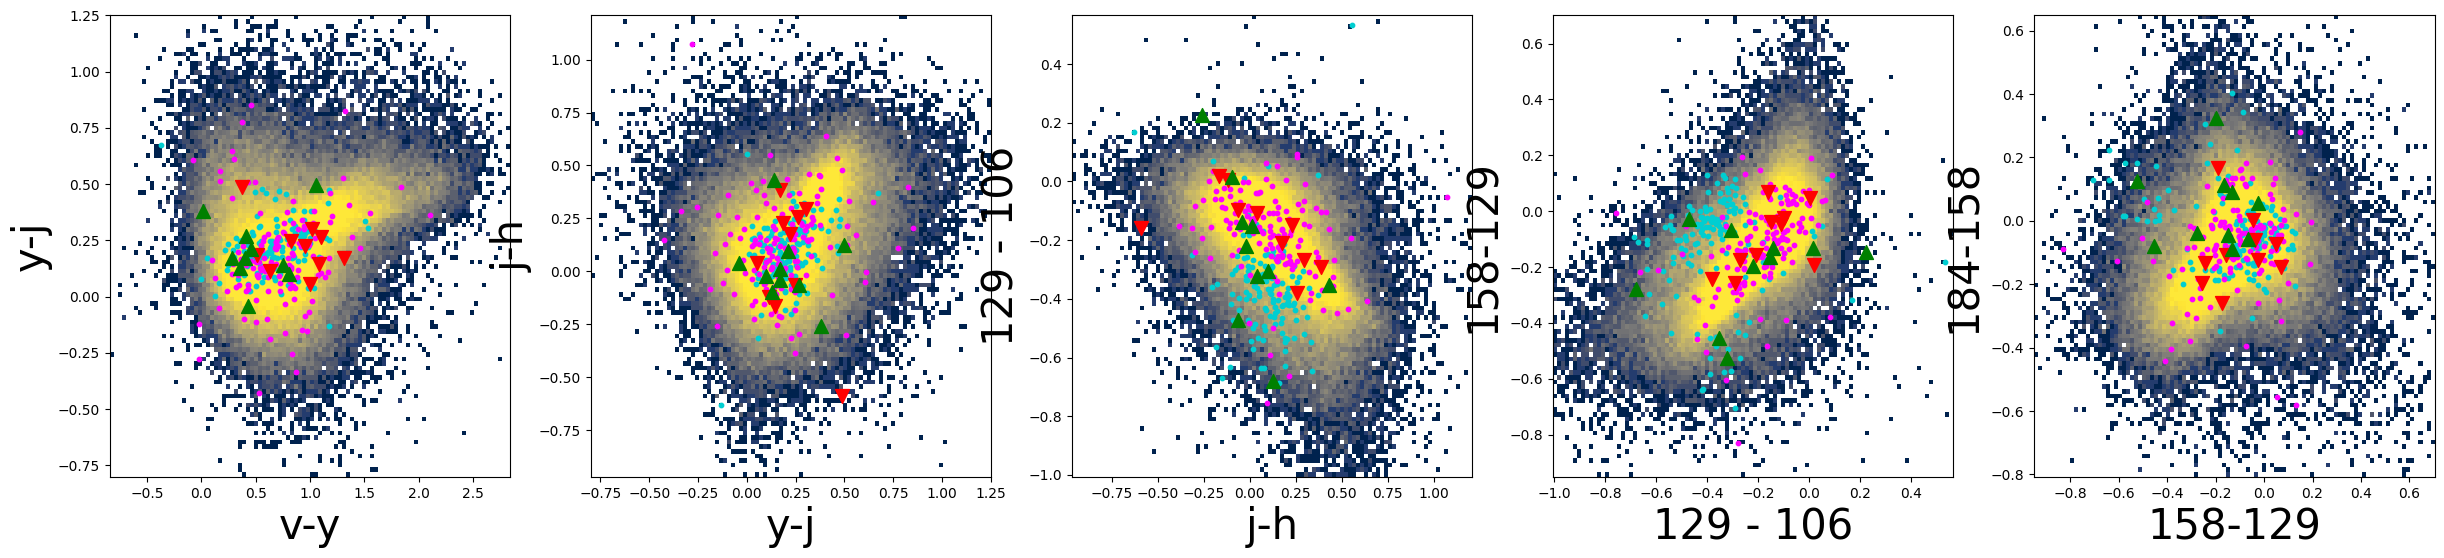

In [ ]:
os = 'Euclid+Roman'

test_best = catalogs[os].iloc[np.array(improved_indexes[os]).flatten()[np.argsort(improved[os])]]
best_subset = catalogs[os].iloc[np.array(improved_indexes[os]).flatten()[np.argsort(improved[os])]][0:10]

test_worst = catalogs[os].iloc[np.array(worsened_indexes[os]).flatten()[np.argsort(worsened[os])]]
worst_subset = catalogs[os].iloc[np.array(worsened_indexes[os]).flatten()[np.argsort(worsened[os])]][0:10]
# print(worsened[os][np.argsort(worsened[os])])

fig,ax = plt.subplots(1,5, figsize = (30, 6))
# fig.tight_layout(pad = 3)

band1 = 'v-y'
band2 = 'y-j'

ax[0].hist2d(catalogs[os][band1], catalogs[os][band2], bins = (100,100), cmap=cmap_choice, norm = colors.LogNorm(vmin=1, vmax=100))
ax[0].scatter(test_best[band1], test_best[band2], s = 10, color = bestcolor)
ax[0].scatter(test_worst[band1], test_worst[band2], s=10, color = worstcolor)
ax[0].scatter(worst_subset[band1],  worst_subset[band2], marker = veryworstmarker, color = 'red', s=size)
ax[0].scatter(best_subset[band1], best_subset[band2], marker = verybestmarker, color = 'green', s=size)
ax[0].set_xlabel(band1, fontsize=fsize)
ax[0].set_ylabel(band2, fontsize=fsize)

band1 = 'y-j'
band2 = 'j-h'

ax[1].hist2d(catalogs[os][band1], catalogs[os][band2], bins = (100,100), cmap=cmap_choice, norm = colors.LogNorm(vmin=1, vmax=100))
ax[1].scatter(test_best[band1], test_best[band2], s = 10, color = bestcolor)
ax[1].scatter(test_worst[band1], test_worst[band2], s=10, color = worstcolor)
ax[1].scatter(worst_subset[band1],  worst_subset[band2], marker = veryworstmarker, color = 'red', s=size)
ax[1].scatter(best_subset[band1], best_subset[band2], marker = verybestmarker, color = 'green', s=size)
ax[1].set_xlabel(band1, fontsize=fsize)
ax[1].set_ylabel(band2, fontsize=fsize)

band1 = 'j-h'
band2 = '129 - 106'

ax[2].hist2d(catalogs[os][band1], catalogs[os][band2], bins = (100,100), cmap=cmap_choice, norm = colors.LogNorm(vmin=1, vmax=100))
ax[2].scatter(test_best[band1], test_best[band2], s=10, color = bestcolor)
ax[2].scatter(test_worst[band1], test_worst[band2], s=10, color = worstcolor)
ax[2].scatter(worst_subset[band1],  worst_subset[band2], marker = veryworstmarker, color = 'red', s=size)
ax[2].scatter(best_subset[band1], best_subset[band2], marker = verybestmarker, color = 'green', s=size)
ax[2].set_xlabel(band1)
ax[2].set_ylabel(band2)
ax[2].set_xlabel(band1, fontsize=fsize)
ax[2].set_ylabel(band2, fontsize=fsize)

band1 = '129 - 106'
band2 = '158-129'

ax[3].hist2d(catalogs[os][band1], catalogs[os][band2], bins = (100,100), cmap=cmap_choice, norm = colors.LogNorm(vmin=1, vmax=100))
ax[3].scatter(test_best[band1], test_best[band2], s=10, color = bestcolor)
ax[3].scatter(test_worst[band1], test_worst[band2], s=10, color = worstcolor)
ax[3].scatter(worst_subset[band1],  worst_subset[band2], marker = veryworstmarker, color = 'red', s=size)
ax[3].scatter(best_subset[band1], best_subset[band2], marker = verybestmarker, color = 'green', s=size)
ax[3].set_xlabel(band1)
ax[3].set_ylabel(band2)
ax[3].set_xlabel(band1, fontsize=fsize)
ax[3].set_ylabel(band2, fontsize=fsize)

band1 = '158-129'
band2 = '184-158'

ax[4].hist2d(catalogs[os][band1], catalogs[os][band2], bins = (100,100), cmap=cmap_choice, norm = colors.LogNorm(vmin=1, vmax=100))
ax[4].scatter(test_best[band1], test_best[band2], s=10, color = bestcolor)
ax[4].scatter(test_worst[band1], test_worst[band2], s=10, color = worstcolor)
ax[4].scatter(worst_subset[band1],  worst_subset[band2], marker = veryworstmarker, color = 'red', s=size)
ax[4].scatter(best_subset[band1], best_subset[band2], marker = verybestmarker, color = 'green', s=size)
ax[4].set_xlabel(band1)
ax[4].set_ylabel(band2)
ax[4].set_xlabel(band1, fontsize=fsize)
ax[4].set_ylabel(band2, fontsize=fsize)

Text(1133.157004830918, 0.5, 'uc-g')

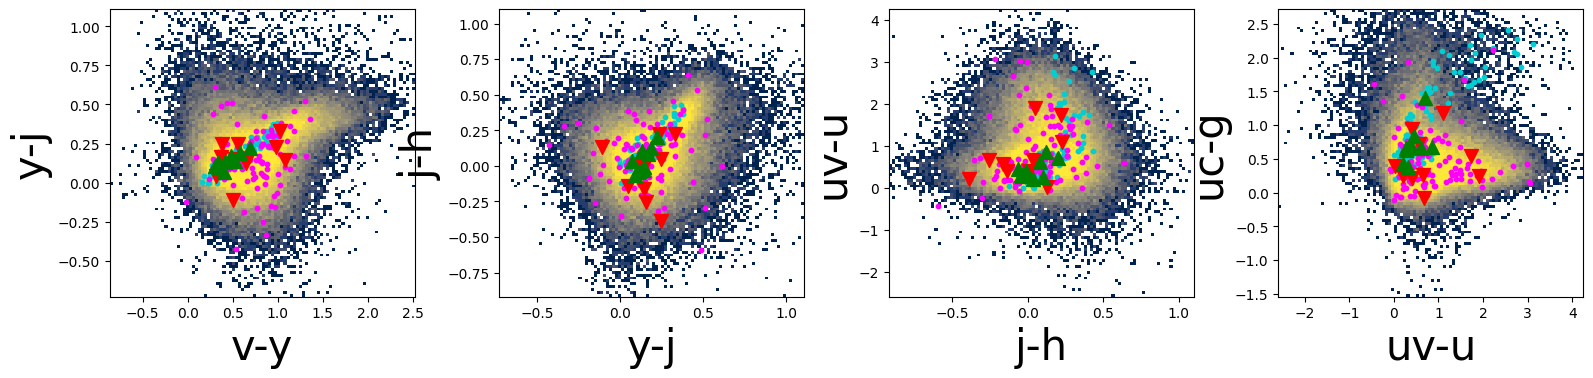

In [ ]:
# Euclid+CASTOR

os = 'Euclid+CASTOR'

test_best = catalogs[os].iloc[np.array(improved_indexes[os]).flatten()[np.argsort(improved[os])]]
best_subset = catalogs[os].iloc[np.array(improved_indexes[os]).flatten()[np.argsort(improved[os])]][0:10]

test_worst = catalogs[os].iloc[np.array(worsened_indexes[os]).flatten()[np.argsort(worsened[os])]]
worst_subset = catalogs[os].iloc[np.array(worsened_indexes[os]).flatten()[np.argsort(worsened[os])]][0:10]
# print(worsened[os][np.argsort(worsened[os])])

fig,ax = plt.subplots(1,4, figsize = (16, 4))
fig.tight_layout(pad = 3)

band1 = 'v-y'
band2 = 'y-j'

ax[0].hist2d(catalogs[os][band1], catalogs[os][band2], bins = (100,100), cmap=cmap_choice, norm = colors.LogNorm(vmin=1, vmax=100))
ax[0].scatter(test_best[band1], test_best[band2], s = 10, color = bestcolor)
ax[0].scatter(test_worst[band1], test_worst[band2], s=10, color = worstcolor)
ax[0].scatter(worst_subset[band1],  worst_subset[band2], marker = veryworstmarker, color = 'red', s=size)
ax[0].scatter(best_subset[band1], best_subset[band2], marker = verybestmarker, color = 'green', s=size)
ax[0].set_xlabel(band1, fontsize=fsize)
ax[0].set_ylabel(band2, fontsize=fsize)

band1 = 'y-j'
band2 = 'j-h'

ax[1].hist2d(catalogs[os][band1], catalogs[os][band2], bins = (100,100), cmap=cmap_choice, norm = colors.LogNorm(vmin=1, vmax=100))
ax[1].scatter(test_best[band1], test_best[band2], s = 10, color = bestcolor)
ax[1].scatter(test_worst[band1], test_worst[band2], s=10, color = worstcolor)
ax[1].scatter(worst_subset[band1],  worst_subset[band2], marker = veryworstmarker, color = 'red', s=size)
ax[1].scatter(best_subset[band1], best_subset[band2], marker = verybestmarker, color = 'green', s=size)
ax[1].set_xlabel(band1, fontsize=fsize)
ax[1].set_ylabel(band2, fontsize=fsize)

band1 = 'j-h'
band2 = 'uv-u'

ax[2].hist2d(catalogs[os][band1], catalogs[os][band2], bins = (100,100), cmap=cmap_choice, norm = colors.LogNorm(vmin=1, vmax=100))
ax[2].scatter(test_best[band1], test_best[band2], s = 10, color = bestcolor)
ax[2].scatter(test_worst[band1], test_worst[band2], s=10, color = worstcolor)
ax[2].scatter(worst_subset[band1],  worst_subset[band2], marker = veryworstmarker, color = 'red', s=size)
ax[2].scatter(best_subset[band1], best_subset[band2], marker = verybestmarker, color = 'green', s=size)
ax[2].set_xlabel(band1, fontsize=fsize)
ax[2].set_ylabel(band2, fontsize=fsize)

band1 = 'uv-u'
band2 = 'uc-g'

ax[3].hist2d(catalogs[os][band1], catalogs[os][band2], bins = (100,100), cmap=cmap_choice, norm = colors.LogNorm(vmin=1, vmax=100))
ax[3].scatter(test_best[band1], test_best[band2], s = 10, color = bestcolor)
ax[3].scatter(test_worst[band1], test_worst[band2], s=10, color = worstcolor)
ax[3].scatter(worst_subset[band1],  worst_subset[band2], marker = veryworstmarker, color = 'red', s=size)
ax[3].scatter(best_subset[band1], best_subset[band2], marker = verybestmarker, color = 'green', s=size)
ax[3].set_xlabel(band1, fontsize=fsize)
ax[3].set_ylabel(band2, fontsize=fsize)

cividis(?)

In [ ]:
catalogs['Euclid+Roman'].keys()

Index(['z_true', 'v', 'v-y', 'y-j', 'j-h', '106', '129 - 106', '158-129',
       '184-158'],
      dtype='object')

Text(1802.0325670498084, 0.5, '184-158')

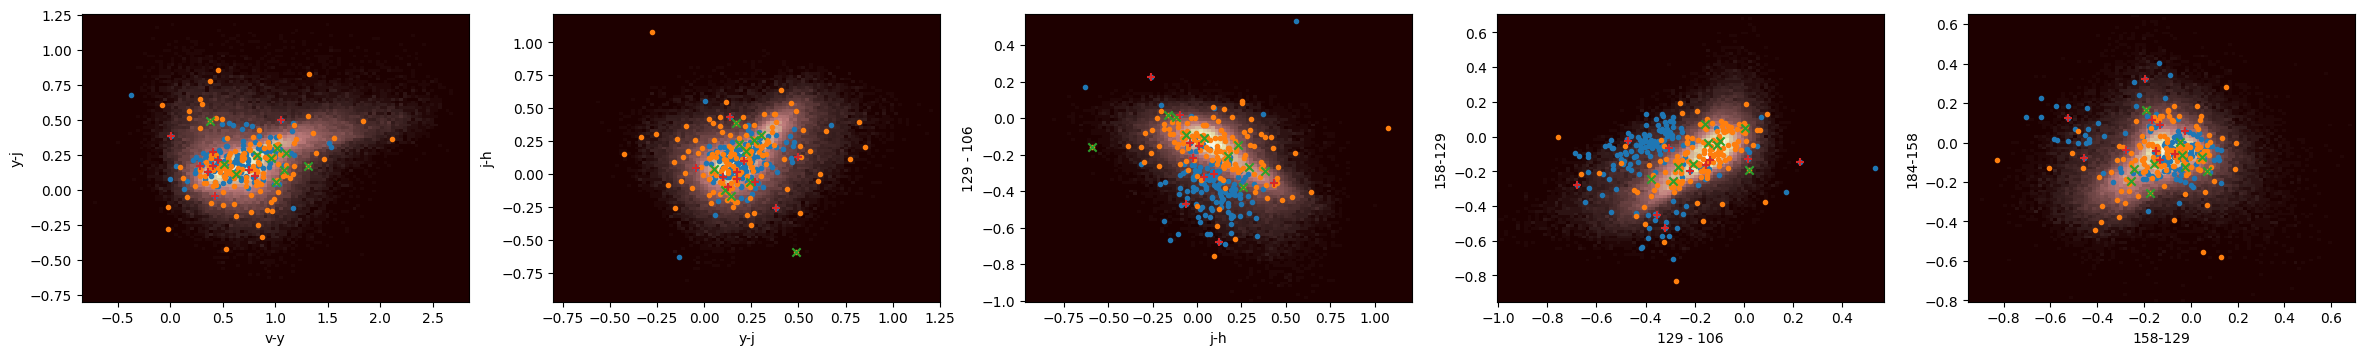

In [ ]:
os = 'Euclid+Roman'

test_best = catalogs[os].iloc[np.array(improved_indexes[os]).flatten()[np.argsort(improved[os])]]
best_subset = catalogs[os].iloc[np.array(improved_indexes[os]).flatten()[np.argsort(improved[os])]][0:10]

test_worst = catalogs[os].iloc[np.array(worsened_indexes[os]).flatten()[np.argsort(worsened[os])]]
worst_subset = catalogs[os].iloc[np.array(worsened_indexes[os]).flatten()[np.argsort(worsened[os])]][0:10]
# print(worsened[os][np.argsort(worsened[os])])

fig,ax = plt.subplots(1,5, figsize = (20, 4))
fig.tight_layout(pad = 3)

band1 = 'v-y'
band2 = 'y-j'

ax[0].hist2d(catalogs[os][band1], catalogs[os][band2], bins = (100,100), cmap='pink')
ax[0].scatter(test_best[band1], test_best[band2], marker = '.')
ax[0].scatter(test_worst[band1], test_worst[band2], marker = '.')
ax[0].scatter(worst_subset[band1],  worst_subset[band2], marker = 'x')
ax[0].scatter(best_subset[band1], best_subset[band2], marker = '+')
ax[0].set_xlabel(band1)
ax[0].set_ylabel(band2)

band1 = 'y-j'
band2 = 'j-h'

ax[1].hist2d(catalogs[os][band1], catalogs[os][band2], bins = (100,100), cmap='pink')
ax[1].scatter(test_best[band1], test_best[band2], marker = '.')
ax[1].scatter(test_worst[band1], test_worst[band2], marker = '.')
ax[1].scatter(worst_subset[band1],  worst_subset[band2], marker = 'x')
ax[1].scatter(best_subset[band1], best_subset[band2], marker = '+')
ax[1].set_xlabel(band1)
ax[1].set_ylabel(band2)

# '129 - 106', '158-129',
#        '184-158'

band1 = 'j-h'
band2 = '129 - 106'

ax[2].hist2d(catalogs[os][band1], catalogs[os][band2], bins = (100,100), cmap='pink')
ax[2].scatter(test_best[band1], test_best[band2], marker = '.')
ax[2].scatter(test_worst[band1], test_worst[band2], marker = '.')
ax[2].scatter(worst_subset[band1],  worst_subset[band2], marker = 'x')
ax[2].scatter(best_subset[band1], best_subset[band2], marker = '+')
ax[2].set_xlabel(band1)
ax[2].set_ylabel(band2)

band1 = '129 - 106'
band2 = '158-129'

ax[3].hist2d(catalogs[os][band1], catalogs[os][band2], bins = (100,100), cmap='pink')
ax[3].scatter(test_best[band1], test_best[band2], marker = '.')
ax[3].scatter(test_worst[band1], test_worst[band2], marker = '.')
ax[3].scatter(worst_subset[band1],  worst_subset[band2], marker = 'x')
ax[3].scatter(best_subset[band1], best_subset[band2], marker = '+')
ax[3].set_xlabel(band1)
ax[3].set_ylabel(band2)

band1 = '158-129'
band2 = '184-158'

ax[4].hist2d(catalogs[os][band1], catalogs[os][band2], bins = (100,100), cmap='pink')
ax[4].scatter(test_best[band1], test_best[band2], marker = '.')
ax[4].scatter(test_worst[band1], test_worst[band2], marker = '.')
ax[4].scatter(worst_subset[band1],  worst_subset[band2], marker = 'x')
ax[4].scatter(best_subset[band1], best_subset[band2], marker = '+')
ax[4].set_xlabel(band1)
ax[4].set_ylabel(band2)


connect with families in SED plots - two families?
fiddle with colors and alphas

Text(769.1928104575164, 0.5, 'uc-g')

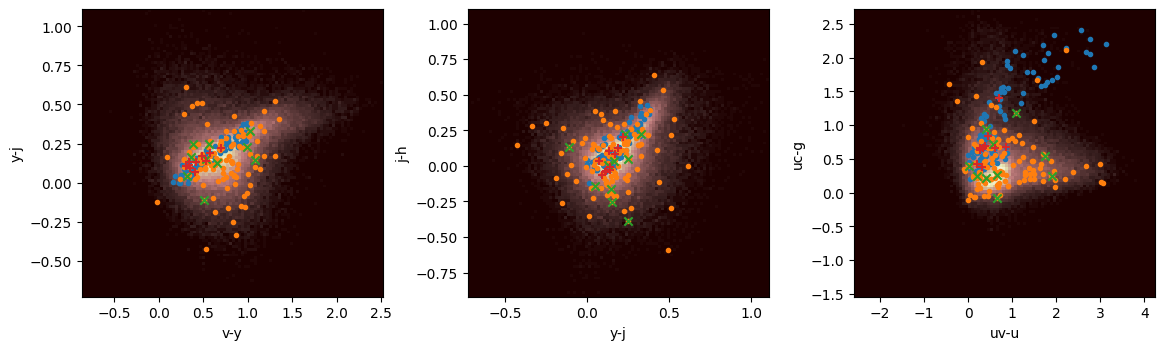

In [ ]:
# Euclid+CASTOR

os = 'Euclid+CASTOR'

test_best = catalogs[os].iloc[np.array(improved_indexes[os]).flatten()[np.argsort(improved[os])]]
best_subset = catalogs[os].iloc[np.array(improved_indexes[os]).flatten()[np.argsort(improved[os])]][0:10]

test_worst = catalogs[os].iloc[np.array(worsened_indexes[os]).flatten()[np.argsort(worsened[os])]]
worst_subset = catalogs[os].iloc[np.array(worsened_indexes[os]).flatten()[np.argsort(worsened[os])]][0:10]
# print(worsened[os][np.argsort(worsened[os])])

fig,ax = plt.subplots(1,3, figsize = (12, 4))
fig.tight_layout(pad = 3)

ax[0].hist2d(catalogs[os]['v-y'], catalogs[os]['y-j'], bins = (100,100), cmap='pink')
ax[0].scatter(test_best['v-y'], test_best['y-j'], marker = '.')
ax[0].scatter(test_worst['v-y'], test_worst['y-j'], marker = '.')
ax[0].scatter(worst_subset['v-y'],  worst_subset['y-j'], marker = 'x')
ax[0].scatter(best_subset['v-y'], best_subset['y-j'], marker = '+')
ax[0].set_xlabel('v-y')
ax[0].set_ylabel('y-j')

ax[1].hist2d(catalogs[os]['y-j'], catalogs[os]['j-h'], bins = (100,100), cmap='pink')
ax[1].scatter(test_best['y-j'], test_best['j-h'], marker = '.')
ax[1].scatter(test_worst['y-j'], test_worst['j-h'], marker = '.')
ax[1].scatter(worst_subset['y-j'],  worst_subset['j-h'], marker = 'x')
ax[1].scatter(best_subset['y-j'], best_subset['j-h'], marker = '+')
ax[1].set_xlabel('y-j')
ax[1].set_ylabel('j-h')

ax[2].hist2d(catalogs[os]['uv-u'], catalogs[os]['uc-g'], bins = (100,100), cmap='pink')
ax[2].scatter(test_best['uv-u'], test_best['uc-g'], marker = '.')
ax[2].scatter(test_worst['uv-u'], test_worst['uc-g'], marker = '.')
ax[2].scatter(worst_subset['uv-u'],  worst_subset['uc-g'], marker = 'x')
ax[2].scatter(best_subset['uv-u'], best_subset['uc-g'], marker = '+')
ax[2].set_xlabel('uv-u')
ax[2].set_ylabel('uc-g')

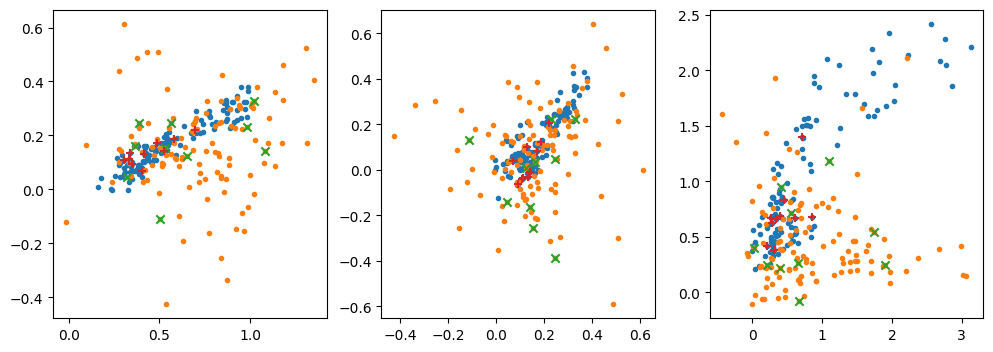

In [ ]:
test_worst = catalogs[os].iloc[np.array(worsened_indexes[os]).flatten()[np.argsort(worsened[os])]]

fig,ax = plt.subplots(1,3, figsize = (12, 4))

ax[0].scatter(test_best['v-y'], test_best['y-j'], marker = '.')
ax[0].scatter(test_worst['v-y'], test_worst['y-j'], marker = '.')
ax[0].scatter(worst_subset['v-y'],  worst_subset['y-j'], marker = 'x')
ax[0].scatter(best_subset['v-y'], best_subset['y-j'], marker = '+')

ax[1].scatter(test_best['y-j'], test_best['j-h'], marker = '.')
ax[1].scatter(test_worst['y-j'], test_worst['j-h'], marker = '.')
ax[1].scatter(worst_subset['y-j'],  worst_subset['j-h'], marker = 'x')
ax[1].scatter(best_subset['y-j'], best_subset['j-h'], marker = '+')

ax[2].scatter(test_best['uv-u'], test_best['uc-g'], marker = '.')
ax[2].scatter(test_worst['uv-u'], test_worst['uc-g'], marker = '.')
ax[2].scatter(worst_subset['uv-u'],  worst_subset['uc-g'], marker = 'x')
ax[2].scatter(best_subset['uv-u'], best_subset['uc-g'], marker = '+')

In [ ]:
catalogs[os].iloc[np.array(improved_indexes[os]).flatten()[np.argsort(improved[os])]][color_col][0:10]

,uv-u
CASTOR_ID,
872162,0.854245
865246,0.445149
589315,0.395039
158731,0.335013
482671,0.203761
258741,0.613906
962226,0.260904
694360,0.704715
940451,0.276926


In [ ]:
catalogs['LSST+CASTOR'].iloc[np.array(improved_indexes['LSST+CASTOR']).flatten()[np.argsort(improved['LSST+CASTOR'])]].index

Index([752211,  72693, 714543, 544307, 479141, 672915, 920324, 562343,  49319,
       278223,
       ...
       558758, 321496, 303687, 924675, 938539, 592223, 582878, 797075, 673422,
       163785],
      dtype='int64', name='CASTOR_ID', length=104)

In [ ]:
np.array(worsened_indexes['Euclid+CASTOR']).flatten()[np.argsort(worsened['Euclid+CASTOR'])]

array([ 73,  76,  81,  38,   6,  16,  24,  53,  25,   7,  96,  83,  92,
        34,  82,  60,   8, 116,  37,   9, 121, 115,  98,  31,  44, 101,
       113,  48, 107,  45,  20,  65,  36,  80,  58,  29,  41, 110, 117,
        15, 103,  59,  74,  79,   2, 111,   1,   3,  66,  49,  47,  89,
        55, 114,  21,  40, 108,  99,  95,  57,  97,  90,  10,  39,  35,
        54,  52,  67,  75,   5,  69, 112,  50,  17,  18, 118, 105,  56,
        91,  13,  43,  11,  87,  30, 119,  23,  64,  93,  33,  22,  86,
        42,   0,  78,  94,  68,  71,  28,  19,  32, 100,  88,  27,  77,
        84,  46,  62,  70, 106,  12,  85, 120, 109, 104,  26,   4, 102,
        14,  63,  61,  51,  72])

In [42]:
cd August_12_dropping_filters_runs

/content/drive/MyDrive/Research/CASTORpz/August_12_dropping_filters_runs


for the survey color-color plots, highlight the survery overlaps in their own row/column

In [43]:
#drop catalogs

drop_cats = {}

drop_cats['all_drop_g'] = FlowEnsemble(file=f"pzflow_ensemble_for_Roman+Euclid+LSST+CASTOR_drop_g.pkl")
drop_cats['castor_drop_g'] = FlowEnsemble(file=f"pzflow_ensemble_for_CASTOR-only_drop_g.pkl")

drop_cats['all_drop_u'] = FlowEnsemble(file=f"pzflow_ensemble_for_Roman+Euclid+LSST+CASTOR_drop_u.pkl")
drop_cats['castor_drop_u'] = FlowEnsemble(file=f"pzflow_ensemble_for_CASTOR-only_drop_u.pkl")

drop_cats['all_drop_uv'] = FlowEnsemble(file=f"pzflow_ensemble_for_Roman+Euclid+LSST+CASTOR_drop_uv.pkl")
drop_cats['castor_drop_uv'] = FlowEnsemble(file=f"pzflow_ensemble_for_CASTOR-only_drop_uv.pkl")




In [44]:
available_os = ['all_drop_g', 'castor_drop_g', 'all_drop_u', 'castor_drop_u', 'all_drop_uv', 'castor_drop_uv']

# just_tav['castor_drop_uv'] = drop_cats['castor_drop_uv'].log_prob(catalogs['CASTOR-only'], returnE)

NameError: name 'returnE' is not defined

In [ ]:
catalogs = {}
just_tav = {}


In [45]:
catalogs['CASTOR-only'] = pd.read_csv('../CASTOR-only-catalog-drop-uv.csv', index_col=0)
catalogs['Roman+Euclid+LSST+CASTOR'] = pd.read_csv('../all-catalog-drop-uv.csv', index_col=0)

In [ ]:
just_tav['all_drop_uv'] = drop_cats['all_drop_uv'].log_prob(catalogs['Roman+Euclid+LSST+CASTOR'], returnEnsemble=True)
just_tav['castor_drop_uv'] = drop_cats['castor_drop_uv'].log_prob(catalogs['CASTOR-only'], returnEnsemble=True)

In [ ]:
 just_tav['castor_drop_uv']

Array([[-0.31446934, -0.24197984, -0.29758883, ..., -0.10525393,
        -0.47369313, -0.2568426 ],
       [-0.8787122 , -0.8862381 , -0.8392756 , ..., -0.8528123 ,
        -0.7919686 , -0.89886117],
       [-0.7995498 , -0.74452233, -0.7865815 , ..., -0.64141464,
        -0.7540417 , -0.6855204 ],
       ...,
       [-1.1110866 , -1.1516802 , -1.1083169 , ..., -1.1095468 ,
        -1.1756865 , -1.1984957 ],
       [-0.4992721 , -0.44334102, -0.4710238 , ..., -0.43436837,
        -0.53167915, -0.39040208],
       [-1.1611876 , -1.2493703 , -1.2552528 , ..., -1.048907  ,
        -1.1406784 , -1.2163615 ]], dtype=float32)

In [19]:
import scipy.stats as sps

In [ ]:
def compute_milb():

  z_true = catalogs['CASTOR-only']['z_true']

  b = sps.mstats.mquantiles(z_true, np.linspace(0,1,101, endpoint=True))

  pz = sps.rv_histogram(np.histogram(z_true, bins=b))
  entropy = pz.entropy()


  milb = just_tav['castor_drop_uv']

  all_milb = np.array(milb)

  all_tlm = milb.mean(axis=1) + entropy

  return all_tlm

In [ ]:
all_tlm2 = compute_milb()

<ipython-input-62-59dac74a9923>:7: RuntimeWarning: Bin widths are not constant. Assuming `density=True`.Specify `density` explicitly to silence this warning.
  pz = sps.rv_histogram(np.histogram(z_true, bins=b))


In [ ]:
def bin_in_redshift(all_tlm):
  zbins = np.linspace(0, 3, 100)

  plotran = np.empty_like(zbins)

  # if 'logprob' not in catalogs['CASTOR-only'].columns.values:
  catalogs['CASTOR-only']['logprob'] = all_tlm2

  for i, zmin in enumerate(zbins[:-1]):
    zmax = zbins[i+1]

    # subset = catalogs['Roman+Euclid+LSST+CASTOR'][(catalogs['Roman+Euclid+LSST+CASTOR']['z_true'] >= zmin) & (catalogs['Roman+Euclid+LSST+CASTOR']['z_true'] < zmax)]
    subset = catalogs['CASTOR-only'][(catalogs['CASTOR-only']['z_true'] >= zmin) & (catalogs['CASTOR-only']['z_true'] < zmax)]

    vals = subset['logprob']
    mean = np.mean(subset['logprob'])

    plotran[i] = mean

  avgtav = plotran

  return avgtav

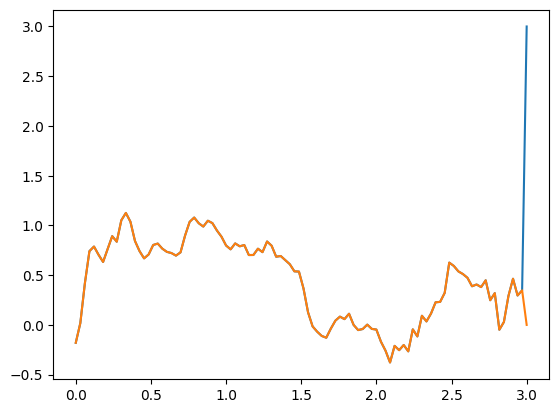

In [ ]:
plt.plot(np.linspace(0, 3, 100), bin_in_redshift(all_tlm))
plt.plot(np.linspace(0, 3, 100), bin_in_redshift(all_tlm2))
# plt.ylim(0,3)

In [14]:
catalogs = {}

catalogs['all_drop_uv'] = pd.read_csv('all_castor_catalogs_drop_uv.csv', index_col=0)
catalogs['all_drop_u'] = pd.read_csv('all_castor_catalogs_drop_u.csv', index_col=0)
catalogs['all_drop_g'] = pd.read_csv('all_castor_catalogs_drop_g.csv', index_col=0)

catalogs['castor_drop_uv'] = pd.read_csv('castor_catalogs_drop_uv.csv', index_col=0)
catalogs['castor_drop_u'] = pd.read_csv('castor_catalogs_drop_u.csv', index_col=0)
catalogs['castor_drop_g'] = pd.read_csv('castor_catalogs_drop_g.csv', index_col=0)

In [50]:
cd ..

/content/drive/MyDrive/Research/CASTORpz


In [15]:
flows = {}

flows['all_drop_g'] = FlowEnsemble(file=f"August_12_dropping_filters_runs/pzflow_ensemble_for_Roman+Euclid+LSST+CASTOR_drop_g.pkl")
flows['castor_drop_g'] = FlowEnsemble(file=f"August_12_dropping_filters_runs/pzflow_ensemble_for_CASTOR-only_drop_g.pkl")

flows['all_drop_u'] = FlowEnsemble(file=f"August_12_dropping_filters_runs/pzflow_ensemble_for_Roman+Euclid+LSST+CASTOR_drop_u.pkl")
flows['castor_drop_u'] = FlowEnsemble(file=f"August_12_dropping_filters_runs/pzflow_ensemble_for_CASTOR-only_drop_u.pkl")

flows['all_drop_uv'] = FlowEnsemble(file=f"August_12_dropping_filters_runs/pzflow_ensemble_for_Roman+Euclid+LSST+CASTOR_drop_uv.pkl")
flows['castor_drop_uv'] = FlowEnsemble(file=f"August_12_dropping_filters_runs/pzflow_ensemble_for_CASTOR-only_drop_uv.pkl")

In [16]:
just_tav = {}

just_tav['all_drop_uv'] = flows['all_drop_uv'].log_prob(catalogs['all_drop_uv'], returnEnsemble=True)
just_tav['castor_drop_uv'] = flows['castor_drop_uv'].log_prob(catalogs['castor_drop_uv'], returnEnsemble=True)

just_tav['all_drop_u'] = flows['all_drop_u'].log_prob(catalogs['all_drop_u'], returnEnsemble=True)
just_tav['castor_drop_u'] = flows['castor_drop_u'].log_prob(catalogs['castor_drop_u'], returnEnsemble=True)

just_tav['all_drop_g'] = flows['all_drop_g'].log_prob(catalogs['all_drop_g'], returnEnsemble=True)
just_tav['castor_drop_g'] = flows['castor_drop_g'].log_prob(catalogs['castor_drop_g'], returnEnsemble=True)

In [75]:
def compute_milb(cat_name, just_tav_name):

  z_true = catalogs[cat_name]['z_true']

  b = sps.mstats.mquantiles(z_true, np.linspace(0,1,101, endpoint=True))

  pz = sps.rv_histogram(np.histogram(z_true, bins=b))
  entropy = pz.entropy()


  milb = just_tav[just_tav_name]

  all_milb = np.array(milb)

  all_tlm = milb.mean(axis=1) + entropy
  # all_tlm_std = milb.std(axis=1)/np.sqrt(milb.shape[1])

  # all_std = np.array(all_tlm_std)

  return all_tlm

def compute_milb2(cat_name, just_tav_name):

  z_true = catalogs[cat_name]['z_true']

  b = sps.mstats.mquantiles(z_true, np.linspace(0,1,101, endpoint=True))

  pz = sps.rv_histogram(np.histogram(z_true, bins=b))
  entropy = pz.entropy()


  milb = just_tav[just_tav_name]

  all_milb = np.array(milb)

  all_tlm = milb + entropy
  # all_tlm_std = milb.std(axis=1)/np.sqrt(milb.shape[1])

  # all_std = np.array(all_tlm_std)

  return all_tlm

In [76]:
all_tlm_u = compute_milb('all_drop_u', 'all_drop_u')
all_tlm_g = compute_milb('all_drop_g', 'all_drop_g')
all_tlm_uv = compute_milb('all_drop_uv', 'all_drop_uv')

<ipython-input-75-533cc0b0d55e>:7: RuntimeWarning: Bin widths are not constant. Assuming `density=True`.Specify `density` explicitly to silence this warning.
  pz = sps.rv_histogram(np.histogram(z_true, bins=b))


In [29]:
np.shape(all_tlm_u[1])

catalogs['all_drop_u']['logprob_std'] = all_tlm_u[1] #standard deviation of tav examples along the ensemble axis




In [79]:
def bin_in_redshift(all_tlm, cat_name):
  zbins = np.linspace(0, 3, 100)

  plotran = np.empty_like(zbins)


  # if 'logprob' not in catalogs['CASTOR-only'].columns.values:
  catalogs[cat_name]['logprob'] = all_tlm

  for i, zmin in enumerate(zbins[:-1]):
    zmax = zbins[i+1]

    # subset = catalogs['Roman+Euclid+LSST+CASTOR'][(catalogs['Roman+Euclid+LSST+CASTOR']['z_true'] >= zmin) & (catalogs['Roman+Euclid+LSST+CASTOR']['z_true'] < zmax)]
    subset = catalogs[cat_name][(catalogs[cat_name]['z_true'] >= zmin) & (catalogs[cat_name]['z_true'] < zmax)]

    vals = subset['logprob']
    mean = np.mean(subset['logprob'])
    plotran[i] = mean


  avgtav = plotran


  return avgtav

In [80]:
bin_in_redshift(all_tlm_u, 'all_drop_u')

array([0.81155175, 1.13966489, 1.59608614, 1.82920945, 1.82613909,
       1.75904191, 1.80037963, 1.94272888, 1.95766664, 2.0250864 ,
       2.15875483, 2.29469442, 2.43143916, 2.36743593, 2.38432527,
       2.2351501 , 2.43530774, 2.52961254, 2.42184043, 2.32799196,
       2.53921413, 2.9417572 , 2.99595475, 2.78735924, 2.94170952,
       2.88572073, 2.61575222, 2.85668945, 2.66624737, 2.79581594,
       2.96710253, 2.82657814, 2.81600809, 2.38838816, 2.22805142,
       2.33222222, 2.30700636, 2.42085862, 2.26241064, 2.55189776,
       2.4442451 , 2.44748402, 2.55176735, 2.34683847, 2.29295373,
       2.45167851, 2.4444778 , 2.32548928, 2.30797434, 2.41079164,
       1.96384597, 1.61863899, 1.51132596, 1.60274851, 1.65440524,
       1.58312285, 1.7456708 , 1.94421315, 1.94153023, 1.87715304,
       1.89036882, 1.7434119 , 1.61638951, 1.65942001, 1.69901228,
       1.75648665, 1.7324127 , 1.64683282, 1.51894891, 1.3023324 ,
       1.47016001, 1.43833363, 1.37350142, 1.37787604, 1.46690

In [2]:
plt.plot(np.linspace(0, 3, 100), bin_in_redshift(all_tlm_u, 'all_drop_u')[0])
plt.plot(np.linspace(0, 3, 100), bin_in_redshift(all_tlm_g, 'all_drop_g')[0])
plt.plot(np.linspace(0, 3, 100), bin_in_redshift(all_tlm_uv, 'all_drop_uv')[0])

plt.ylim(0,3)

plt.show()

castor_tlm_u = compute_milb('castor_drop_u', 'castor_drop_u')
castor_tlm_g = compute_milb('castor_drop_g', 'castor_drop_g')
castor_tlm_uv = compute_milb('castor_drop_uv', 'castor_drop_uv')

plt.plot(np.linspace(0, 3, 100), bin_in_redshift(castor_tlm_u, 'castor_drop_u')[0], label = 'drop_u')
plt.plot(np.linspace(0, 3, 100), bin_in_redshift(castor_tlm_g, 'castor_drop_g')[0], label = 'drop_g')
plt.plot(np.linspace(0, 3, 100), bin_in_redshift(castor_tlm_uv, 'castor_drop_uv')[0], label = 'drog_uv')

plt.ylim(-1,3)
plt.legend()

plt.show()

NameError: name 'plt' is not defined

(array([-3.36366206e-01, -2.34067857e-01,  1.77563690e-02,  2.39551112e-01,
         3.61270487e-01,  4.24627066e-01,  4.88999903e-01,  7.23349035e-01,
         9.02315915e-01,  8.93019915e-01,  1.10944200e+00,  1.18036664e+00,
         1.18568468e+00,  1.05019510e+00,  9.84086812e-01,  8.80246341e-01,
         9.80171621e-01,  9.45764005e-01,  9.94895220e-01,  9.43812072e-01,
         9.32669163e-01,  9.38305736e-01,  8.91457915e-01,  8.45306814e-01,
         9.57383275e-01,  1.11882019e+00,  1.12769520e+00,  1.06404352e+00,
         1.01348209e+00,  1.10273039e+00,  1.07563126e+00,  1.02283752e+00,
         9.91441905e-01,  9.20164704e-01,  8.94771636e-01,  8.87924850e-01,
         8.29576492e-01,  8.13840270e-01,  7.44842350e-01,  7.64406919e-01,
         7.80134141e-01,  7.51054347e-01,  7.78945565e-01,  7.36649394e-01,
         7.34648466e-01,  7.92426288e-01,  7.78764844e-01,  7.40166903e-01,
         7.58976221e-01,  7.62061059e-01,  5.36919832e-01,  3.65604013e-01,
         3.1

In [ ]:
plt.figure(figsize=(10, 6))

zbins = np.linspace(0, 3, 100)

castor_tlm_u = compute_milb('castor_drop_u', 'castor_drop_u')[0]
castor_tlm_g = compute_milb('castor_drop_g', 'castor_drop_g')[0]
castor_tlm_uv = compute_milb('castor_drop_uv', 'castor_drop_uv')[0]

epistemic_standard_error_u = compute_milb('castor_drop_u', 'castor_drop_u')[1]
epistemic_standard_error_g = compute_milb('castor_drop_g', 'castor_drop_g')[1]
epistemic_standard_error_uv = compute_milb('castor_drop_uv', 'castor_drop_uv')[1]

castor_binned_drop_u = bin_in_redshift(castor_tlm_u, 'castor_drop_u')[0]
castor_binned_drop_uv = bin_in_redshift(castor_tlm_uv, 'castor_drop_uv')[0]
castor_binned_drop_g = bin_in_redshift(castor_tlm_g, 'castor_drop_g')[0]

castor_binner_error_drop_u = bin_in_redshift(castor_tlm_u, 'castor_drop_u')[1]
castor_binner_error_drop_uv = bin_in_redshift(castor_tlm_uv, 'castor_drop_uv')[1]
castor_binner_error_drop_g = bin_in_redshift(castor_tlm_g, 'castor_drop_g')[1]

plt.plot(zbins, bin_in_redshift(castor_tlm_u, 'castor_drop_u')[0], label = 'drop_u', color = '#7FFFD4')
plt.plot(zbins, bin_in_redshift(castor_tlm_g, 'castor_drop_g')[0], label = 'drop_g', color = '#00008B')
plt.plot(zbins, bin_in_redshift(castor_tlm_uv, 'castor_drop_uv')[0], label = 'drog_uv', color = '#800080')

plt.fill_between(zbins, castor_binned_drop_u - castor_binner_error_drop_u - epistemic_standard_error_u, castor_binned_drop_u + castor_binner_error_drop_u + epistemic_standard_error_u, alpha = 0.2, color = '#7FFFD4')
plt.fill_between(zbins, castor_binned_drop_uv - castor_binner_error_drop_uv - epistemic_standard_error_uv, castor_binned_drop_uv + castor_binner_error_drop_uv + epistemic_standard_error_uv, alpha = 0.2, color = '#00008B')
plt.fill_between(zbins, castor_binned_drop_g - castor_binner_error_drop_g - epistemic_standard_error_g, castor_binned_drop_g + castor_binner_error_drop_g + epistemic_standard_error_g, alpha = 0.2, color = '#800080')


# plt.errorbar(np.linspace(0, 3, 100), bin_in_redshift(castor_tlm_u, 'castor_drop_u')[0],bin_in_redshift(castor_tlm_u, 'castor_drop_u')[1], label = 'drop_u', alpha = 0.5)
# plt.errorbar(np.linspace(0, 3, 100), bin_in_redshift(castor_tlm_g, 'castor_drop_g')[0], bin_in_redshift(castor_tlm_g, 'castor_drop_g')[1], label = 'drop_g', alpha = 0.5)
# plt.errorbar(np.linspace(0, 3, 100), bin_in_redshift(castor_tlm_uv, 'castor_drop_uv')[0], bin_in_redshift(castor_tlm_uv, 'castor_drop_uv')[1], label = 'drog_uv', alpha = 0.5)


plt.ylim(-1.5,3.3)
plt.xlabel('z$_{true}$', fontsize=16)
plt.ylabel(chr(0x05ea), fontsize=16)
plt.legend(fontsize=16)

plt.tick_params(axis='both', which='major', labelsize=16)
plt.tick_params(axis='both', which='minor', labelsize=16)

In [39]:
all_tlm_u = compute_milb('castor_drop_u', 'castor_drop_u')

<ipython-input-33-51c5c37724be>:7: RuntimeWarning: Bin widths are not constant. Assuming `density=True`.Specify `density` explicitly to silence this warning.
  pz = sps.rv_histogram(np.histogram(z_true, bins=b))


In [56]:

epistemic_variance = {}
redshifts = {}

zbins = np.linspace(0,3, 100)

epistemic_variance['drop_u'] = all_tlm_u.std(axis=1)/np.sqrt(all_tlm_u.shape[1])
redshifts['drop_u'] = catalogs['castor_drop_u']['z_true']

binned_variance = {}

print(len(epistemic_variance['drop_u']))

ploterr = np.empty_like(zbins)
stat_err = np.empty_like(zbins)

for i, zmin in enumerate(zbins[:-1]):
    zmax = zbins[i+1]
    # Find indices of redshifts within the bin
    indices = np.where((redshifts['drop_u'] >=zmin) & (redshifts['drop_u'] < zmax))[0]
    # Calculate mean epistemic variance using the indices
    if indices.size > 0: # Check if any redshifts fall within the bin
        ploterr[i] = np.mean(epistemic_variance['drop_u'][indices])
        stat_err[i] = np.std(all_tlm_u[indices])/np.sqrt(len(all_tlm_u[indices]))
    else:
        ploterr[i] = np.nan # or any other appropriate value for empty bins
        stat_err[i] = np.nan

    binned_variance['drop_u'] = np.sqrt(ploterr*ploterr + stat_err*stat_err)

94548


(0.0, 0.1)

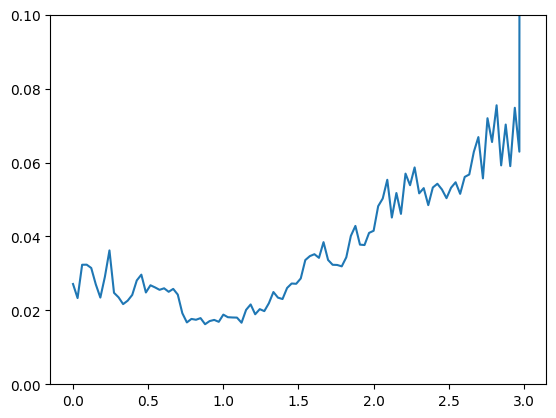

In [57]:
plt.plot(zbins, binned_variance['drop_u'])
plt.ylim(0, 0.1)

(0.0, 6.0)

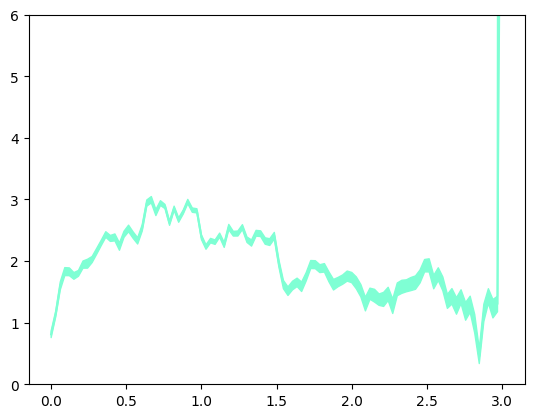

In [88]:
plt.plot(zbins, bin_in_redshift(all_tlm_u, 'castor_drop_u'), label = 'drop_u', color = '#7FFFD4')

plt.fill_between(zbins, bin_in_redshift(all_tlm_u, 'castor_drop_u') - 2*binned_variance['drop_u'], bin_in_redshift(all_tlm_u, 'castor_drop_u') + 2*binned_variance['drop_u'], alpha = 1, color = '#7FFFD4')
plt.ylim(0,6)
